In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import networkx as nx
import pandas as pd
import numpy as np
import os
from itertools import groupby

In [2]:
def gillespieSIRV(G, beta, mu, t_max, strategies):
    '''
    This function simulates a SIRV process on a Graph G using the Gillespie algorithm
    
    Arguments:
    
    G        : graph on which to operate
    beta     : transmissibility of the disease
    mu       : recovery rate of the disease
    t_max    : t_max of the simulation
    strategies : list with strategies node adopts, can be either vaccinated or susceptible 
    
    OUTPUT:
    results:
       -time at which system changed status
       -S : fraction of Susceptible
       -I : fraction of Infected
       -R : fraction of Recovered
       -V : vaccined people, not susceptible and look like recovered
    '''
    
    statuses = strategies.copy()
    
    #INITIALIZATION VARIABLES
    N = nx.number_of_nodes(G)
    S = statuses.count('S')
    I = 0
    R = 0
    V = statuses.count('V')
    
    infected_nodes = set()
    at_risk_nodes  = set()
    
    infection_rate = np.zeros((N))
    infection_rate_prob = []
    
    columns = ['Time', 'S', 'I', 'R', 'V']
    results = pd.DataFrame(columns=columns)
    
    #Set the seed, select a node at random with the condition that must be susceptible to start the infection
    while True:
        seed = np.random.choice(range(len(statuses)))
        if statuses[seed] == 'S':
            break
    #the extremal condition where all nodes are vaccined are dealt by swapping any node to a 'S' one
        if all_equal(statuses):
            statuses[seed] = 'S'
            break
            
    #add the seed to infected nodes and update accordingly
    infected_nodes.add(seed)
    statuses[seed] = 'I'
    S = S-1
    I = I+1
    
    #update the "at risk nodes", but first check whether it's vaccined
    for i in G.neighbors(seed):
        #if it is not vaccined, then it is susceptible and add it to risk nodes
        if statuses[seed] != 'V': 
            at_risk_nodes.add(i)
            infection_rate_prob.append(i)
            infection_rate[i] += beta
        #if it is vaccined, then skip
        else: continue
    
    #computes the rates of the next event
    total_infection_rate = np.sum(infection_rate)
    total_recovery_rate = mu*float(len(infected_nodes))
    total_rate = total_infection_rate + total_recovery_rate
    
    results.loc[len(results)] = [0.0,
                                 S/float(N),
                                 I/float(N),
                                 R/float(N),
                                 V/float(N)]
    
    #timing of the first event
    time = np.random.exponential(1.0/total_rate)

    #dynamic starts
    #while time < t_max and total_rate > 0:
    while total_rate > 0:
        
        #draw a random number between 0 and total rate 
        #total rate = infection rate + recovery rate
        rnd = np.random.uniform(0, total_rate)
        
        #recovery phase
        if rnd < total_recovery_rate:
            
            node = np.random.choice(list(infected_nodes))
            infected_nodes.remove(node)
            statuses[node] = 'R'
            I = I - 1
            R = R + 1 
            
            for i in G.neighbors(node):
                
                if statuses[i] == 'S':
                    
                    infection_rate[i] -= beta
                    
                    #needed, check 
                    if infection_rate[i] == 0.0:
                        at_risk_nodes.remove(i)
                    
                    infection_rate_prob.remove(i)
        else:
            
            #infection phase
            node = np.random.choice(infection_rate_prob)
            
            at_risk_nodes.remove(node)
            infected_nodes.add(node)
            
            infection_rate[node] = 0.0
            #infection_rate_prob.remove(node)
            infection_rate_prob  = [j for j in infection_rate_prob if j != node]

            statuses[node] = 'I'
            S = S - 1
            I = I + 1
            
            for i in G.neighbors(node):
                
                if statuses[i] == 'S':
                    
                    at_risk_nodes.add(i)
                    infection_rate[i] += beta
                    infection_rate_prob.append(i)
                        
        results.loc[len(results)] = [time,
                            S/float(N),
                            I/float(N),
                            R/float(N),
                            V/float(N)]
        
        #computes rates for the next event
        total_infection_rate = np.sum(infection_rate)
        total_recovery_rate  = mu*float(len(infected_nodes))
        total_rate = total_infection_rate + total_recovery_rate
        
        if total_rate > 0:
            time += np.random.exponential(1.0/total_rate)
    
    return results, statuses

def map_status_to_value(statuses_list):
    vals = []
    for i in statuses_list:
        if i == 'V':
            vals.append(0)
        elif i == 'S':
            vals.append(1)
        elif i == 'I':
            vals.append(2)
        elif i == 'R':
            vals.append(3)
        
    return np.array(vals)

def get_threshold_immunity(beta, mu, av_k):
    herd_threshold = 1 - (av_k*beta/mu)**(-1)
    print(f"Herd immunity threshold is: {herd_threshold}")
    
    return herd_threshold

#Strategy Adaptation: The Original Individual-Based Risk Assessment (IB-RA)
def IB_RA_update(old_strategy, payoff_list, G):
    
    #Initialize the new statuses array
    new_strategy = ['']*len(old_strategy)
    
    for i in range(len(old_strategy)):
        i_node_payoff = payoff_list[i]
        #pick a neighbor of node i at random
        neighbor = np.random.choice(list(G.neighbors(i)))
        #compute the probability to flip the status of a node
        prob = Fermi_function( i_node_payoff - payoff_list[neighbor]) 
        if np.random.random() < prob:
            #copy the strategy of the other node
            new_strategy[i]  = old_strategy[neighbor]
        #else do nothing and keep the same strategy
        else: new_strategy[i]  = old_strategy[i]
    
    return new_strategy

#update using The Strategy-Based Risk Assessment (SB-RA)
def SB_RA_update(old_strategy, payoff_list, G, sampling_param):
    
    #Initialize the new statuses array
    new_strategy = ['']*len(old_strategy)

    for i in range(len(old_strategy)):
        i_node_payoff = payoff_list[i]
        
        #pick a neighbor of node i at random, this will be "j" in the formula
        neighbor = np.random.choice(list(G.neighbors(i)))
        
        #expected payoff for a vaccined node is the one of all vaccined (e.g. -C_r)
        if old_strategy[neighbor] == 'V':
            neighbor_payoff = i_node_payoff
        #if neighbour node was not vaccined, then look at the others node that were not vaccined 
        #(up to sampling parameter) and compute an "average" payoff for not being vaccined 
        elif old_strategy[neighbor] == 'S':
            neighbor_payoff = 0
            #if sampling parameter is zero then use the whole network
            if (sampling_param == 0):
                #number of -1 in the payoff are the people who didn't vaccine and got infected
                infected = (payoff_list == -1).sum()
                #number of 0 in the payoff are free riders
                free_riders = (payoff_list == 0).sum()
                neighbor_payoff = -infected/(infected+free_riders)
            #if sampling parameter is 1 then go back to the IB-RA case and use the j-th neighbor payoff
            elif (sampling_param == 1):
                neighbor_payoff = payoff_list[neighbor]
            else:
            #if sampling parameter is more than 1 then pick a number "sampling parameter" nodes that didn't vaccine
            #and see which is their payoff. Then, take the average.
                indices = [i for i, x in enumerate(old_strategy) if x == "S"]
                for j in range(sampling_param):
                    neighbor_payoff += payoff_list[np.random.choice(indices)]
                neighbor_payoff /= sampling_param
                
        #compute the probability to flip the status of a node
        prob = Fermi_function( i_node_payoff - neighbor_payoff) 
        if np.random.random() < prob:
            #copy the strategy of the other node
            new_strategy[i]  = old_strategy[neighbor]
        #else do nothing and keep the same strategy
        else: new_strategy[i]  = old_strategy[i]
    
    return new_strategy

def get_payoff(statuses, cost_vacc, N):
    payoff = []
    
    for i in statuses:
        if   i == 'S': payoff.append(0.)
        elif i == 'R': payoff.append(-1.)
        elif i == 'V': payoff.append(-cost_vacc)
            
    return np.array(payoff)

#k is the selection pressure, i.e. the lower the more sensible they are wrt the payoff difference
def Fermi_function(x, k = 0.1):
    return(1./(1. + np.exp(x/k)))

def plot_strategy_square_lattice(strategy, N, title = '', saveflag = False, iteration = '', update_rule = 'update', Cr = '' ):
    
    values = map_status_to_value(strategy).reshape((N,N))
    
    #individual can only cooperate (blue) or defect (red)
    cMap = ListedColormap(['blue', 'red'])
    
    fig, ax = plt.subplots(figsize = (8,8))
    img = ax.imshow(values, cmap=cMap)

    #legend
    cbar = plt.colorbar(img)
    #empty the ticks of cbar
    cbar.ax.get_yaxis().set_ticks([])
    for j, lab in enumerate(['C', 'D']):
        cbar.ax.text(0.5, 0.30 + 0.45*j, lab, ha = 'center', va ='center', fontsize = '25')
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Strategy', rotation = 90, fontsize = '25')

    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xlim([-.5,float(N)-0.5])
    ax.set_ylim([-.5,float(N)-0.5])
    
    #set the ticks properly
    ax.set_xticks(np.arange(-.5, N , 1))
    ax.set_yticks(np.arange(-.5, N , 1))
    
    #empty the ticks of the picture/fig
    empty_string_labels = ['']*len(np.arange(-.5, N , 1))
    ax.set_xticklabels(empty_string_labels)
    ax.set_yticklabels(empty_string_labels)
    ax.invert_yaxis()
    ax.set_title(str(title), fontsize = '25')
    if (saveflag):
        if (iteration == ''):
            output_dir = 'images/Cr_'+str(Cr)+"/"
            os.makedirs(output_dir,exist_ok=True)
            plt.savefig(output_dir+title+'strategy.png')
            plt.close()
        else:  
            output_dir = 'images/Cr_'+str(Cr)+'/'+update_rule+"/"
            os.makedirs(output_dir,exist_ok=True)
            plt.savefig(output_dir+update_rule+'strategy'+str(iteration)+'.png')
            plt.close()
    else:  
        plt.show()    
    return

def plot_SIRV_results_square_lattice(statuses, N, saveflag = False, iteration = '', update_rule = 'update', Cr = '' ):
    
    values = map_status_to_value(statuses).reshape((N,N))
    cMap = ListedColormap(['white', 'green', 'yellow','red'])
    
    fig, ax = plt.subplots(figsize = (10,10))
    img = ax.imshow(values, cmap=cMap)

    #legend
    cbar = plt.colorbar(img)
    #empty the ticks of cbar
    cbar.ax.get_yaxis().set_ticks([])
    for j, lab in enumerate(['V', 'S', 'I', 'R']):
        cbar.ax.text(1.5, 0.75*j+0.35, lab, ha='center', va ='center', fontsize = '25')
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Node type', rotation=90, fontsize = '25')

    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xlim([-.5,float(N)-0.5])
    ax.set_ylim([-.5,float(N)-0.5])
    
    #set the ticks properly
    ax.set_xticks(np.arange(-.5, N , 1))
    ax.set_yticks(np.arange(-.5, N , 1))
    
    #empty the ticks of the picture/fig
    empty_string_labels = ['']*len(np.arange(-.5, N , 1))
    ax.set_xticklabels(empty_string_labels)
    ax.set_yticklabels(empty_string_labels)
    ax.invert_yaxis()
    plt.title('SIRV - final snapshot', fontsize = '25')
    if (saveflag):
        if (iteration == ''):
            output_dir = 'images/Cr_'+str(Cr)+'/'+update_rule+"/"
            os.makedirs(output_dir,exist_ok=True)
            plt.savefig(output_dir+'/SIRV.png')
            plt.close()
        else:
            output_dir = 'images/Cr_'+str(Cr)+'/'+update_rule+"/"
            os.makedirs(output_dir,exist_ok=True)
            plt.savefig(output_dir+'/SIRV_iter'+str(iteration)+'.png')
            plt.close()
    else:  
        plt.show()    
    return


def all_equal(iterable):
    g = groupby(iterable)
    return next(g, True) and not next(g, False)

# Initialization of simulation parameters

In [3]:
#truncate the number as "d.xx"
Cr_list_str = ["{:3.2f}".format(i*0.05) for i in range(21)]
Cr_list     = [float(i) for i in Cr_list_str]

#Epidemiological parameters for SIR-V Gillespie algorithm
beta = 1.0
mu   = 0.4

#Network Stuff, number of nodes in the 2-dim lattic
N = 50

#Number of timesteps to simulate
timesteps = 200

In [4]:
#Simple contagion parameters
prob_contagion = 0.5
dose_dim_rate  = 0.25
contagion_threshold = 2.

In [5]:
folder_path = 'sim_results/'
os.makedirs(folder_path,exist_ok=True)

# IB_RA update

In [6]:
# for vacc_cost in Cr_list:
    
#     vacc_cost_str = str(vacc_cost)
#     print("Vaccination cost is: ", vacc_cost_str)

#     #initialization
#     G = nx.grid_2d_graph(N, N)
#     G = nx.convert_node_labels_to_integers(G)

#     #graph is regular, therefore R_0 = beta*av_k/mu
#     av_k     = np.mean([val for (node, val) in G.degree()])
#     R_0      = (beta/mu)*av_k
#     strategy = nx.number_of_nodes(G)*['S']

#     #set initial seed
#     np.random.seed(10)

#     #initialize randomly
#     for i in range(1250):
#         seed = np.random.choice(range(len(strategy)))
#         strategy[seed] = 'V'
#     print("Fraction of population vaccinated is:", strategy.count('V')/(N*N))
#     print("R_0 of the disease is:",)

#     #initialize the result dataframe
#     init_strat = strategy.copy()
#     columns = ['Iteration', 'VaccineCoverage', 'TotalInfected', 'MaxInfected', 'AverageSocialPayoff']
#     results = pd.DataFrame(columns=columns)

#     #dynamics using IB_RA update
#     for i in range(timesteps):
#         print(i,"/",timesteps)
#         df, statuses   = gillespieSIRV(G, beta, mu, 1000, strategy)
#         payoffs_values = get_payoff(statuses, vacc_cost, N)
#         new_strategies = IB_RA_update(strategy, payoffs_values, G)
#         strategy       = new_strategies.copy()

#         #update the dataframe
#         vacc_cover   = strategy.count('V')/(N*N)
#         total_infec  = df.tail(1).R.values[0]
#         av_payoff    = np.mean(payoffs_values)
#         max_infected = max(df.I)
#         results.loc[len(results)] = [i + 1, vacc_cover, total_infec, max_infected, av_payoff]
        
#         #plot everything
# #         plot_SIRV_results_square_lattice(statuses, N, False, iteration = str(i), update_rule = 'IB_RA', Cr = vacc_cost_str )
# #         plot_strategy_square_lattice(strategy, N, '', False, iteration = str(i), update_rule = 'IB_RA', Cr = vacc_cost_str )
        
        
#     results.to_csv('sim_results/IB_RA_Cr_'+vacc_cost_str+'.csv', index = False)
#     plot_strategy_square_lattice(init_strat, N, "Initial", True, iteration = '', update_rule = 'IB_RA', Cr = vacc_cost_str)
#     plot_strategy_square_lattice(strategy, N, "Final", True, iteration = '', update_rule = 'IB_RA', Cr = vacc_cost_str)
    
#     #delete all the variables to free memory at every iteration
#     del results, statuses, df, payoffs_values, init_strat, strategy, G


# SB_RA update

In [7]:
# for vacc_cost in Cr_list:
#     vacc_cost_str = str(vacc_cost)
#     print("Vaccination cost is: ", vacc_cost_str)

#     #initialization
#     G = nx.grid_2d_graph(N, N)
#     G = nx.convert_node_labels_to_integers(G)

#     #graph is regular, therefore R_0 = beta*av_k/mu
#     av_k     = np.mean([val for (node, val) in G.degree()])
#     R_0      = (beta/mu)*av_k
#     strategy = nx.number_of_nodes(G)*['S']

#     #set initial seed
#     np.random.seed(10)

#     #initialize randomly
#     for i in range(1250):
#         seed = np.random.choice(range(len(strategy)))
#         strategy[seed] = 'V'
#     print("Fraction of population vaccinated is:", strategy.count('V')/(N*N))
#     print("R_0 of the disease is:", R_0)

#     #initialize the result dataframe
#     init_strat = strategy.copy()
#     columns = ['Iteration', 'VaccineCoverage', 'TotalInfected', 'MaxInfected', 'AverageSocialPayoff']
#     results = pd.DataFrame(columns=columns)

#     #dynamics using SB_RA update
#     for i in range(timesteps):
#         print(i,"/",timesteps)
#         df, statuses   = gillespieSIRV(G, beta, mu, 1000, strategy)
#         payoffs_values = get_payoff(statuses, vacc_cost, N)
#         new_strategies = SB_RA_update(strategy, payoffs_values, G, 0)
#         strategy       = new_strategies.copy()

#         #update the dataframe
#         vacc_cover   = strategy.count('V')/(N*N)
#         total_infec  = df.tail(1).R.values[0]
#         av_payoff    = np.mean(payoffs_values)
#         max_infected = max(df.I)
#         results.loc[len(results)] = [i + 1, vacc_cover, total_infec, max_infected, av_payoff]
        
#             #plot everything
# #         plot_SIRV_results_square_lattice(statuses, N, False, iteration = str(i), update_rule = 'IB_RA', Cr = vacc_cost_str )
# #         plot_strategy_square_lattice(strategy, N, '', False, iteration = str(i), update_rule = 'IB_RA', Cr = vacc_cost_str )
    
#     results.to_csv('sim_results/SB_RA_Cr_'+vacc_cost_str+'.csv', index = False)
#     plot_strategy_square_lattice(init_strat, N, "Initial", True, iteration = '', update_rule = 'SB_RA', Cr = vacc_cost_str)
#     plot_strategy_square_lattice(strategy, N, "Final", True, iteration = '', update_rule = 'SB_RA', Cr = vacc_cost_str)
    
#     #delete all the variables to free memory at every iteration
#     del results, statuses, df, payoffs_values, init_strat, strategy, G


# Simple Contagion update

Using as reference some concepts pointed out here https://arxiv.org/abs/1408.2701 for the simple contagion model we are trying to understand what can be the role of a spreader of Fake News, that can convince its neighbors to vaccinate.

Our main **assumptions** are:
   * There are some nodes, which initial number can be tuned, that spread some fake news and try to convince their neighbors to not vaccinate for the next season.
   
   * At every season the update of strategy follows what implemented in the Strategy-Based Risk Assessment (SB-RA): the payoff of every node is compared to the average payoff that came with opponent's strategy. An opponent is a randomly selected neighbor of the node that is updating its own strategy
   
   * In this way we assume there is a "common knowledge" about the payoff for a given strategy, therefore a shared information among the entire network. This can be obtained by the means of media or governement awareness campaings pro-vaccine. 
   
## Algorithm

It mainly differs from the normal SB-RA in the following way. For every node "i" in the lattice:
   
   1. We select a neighbour "j" of it
   
   + If the selected node "j" is a spreader of Fake News, it infects the node "i" with probability p. If this contagion is successful, the node "i" receives a "dose" whose value is fixed to 1. In addition, for the next season it will not vaccinate no matter what. If value of the cumulated dose is above a certain threshold, that can be tuned, the node "i" becomes a spreader of Fake-News itself.
      
   +  If the selected node "j" is **not** a spreader of Fake News, use normal SB-RA updating rule.
   
   2. At every turn the array containing the cumulated dose decreases by a fixed quantity.
   
Number of initial spreaders of Fake News, the dose diminishing ratio per every season, threshold above which a node can be considered "infected" and start spreading Fake News, and finally probability of successful infectious contact are parameters to be tuned.

We keep as fixed:
 * **dose diminishing rate** = 0.25 (every season the dose accumulated decreases by 0.25) 
 * **threshold dose for contagion** = 2.0 (a node starts spreading fake news after its dose overceeds 2.0) 
 * **probability successful contact** = 0.5 (every contact has a probability 1/2 to be successful)
 
However, because of the dose diminishing rate, there must be three successful contacts for a given node with a spreader within 10 seasons to overcome the threshold and start spreading Fake-news itself. 

In addition for the topology of the network every node has 4 on average neighbors, the probability for each of them to draw a fake news spreader, given they have one as neighbor, is 1/4. The elapsed time until the next infection follows a geometric random variable, whose expected value is 4. On the contrary, every 4 turns, a node loses all its cumulated dose if no contagion has occurred in the meanwhile. Hence, on average, number of spreader of Fake-News remains pretty low and around the starting one, unless some stochastic oscillations.

We vary:
 * Number of starting spreaders of Fake news = 1, 2



# SB_RA + Simple contagion: update function

In [8]:
#update using The Strategy-Based Risk Assessment (SB-RA) and simple contagion model!
def FN_SB_RA_update(old_strategy, payoff_list, doses, spreaders,
                    prob_contagion, contagion_threshold, dose_dim_rate,
                    G, sampling_param):
    
    #Initialize the new statuses array
    new_strategy = ['']*len(old_strategy)

    #update the doses cumulated list and diminish the dose by a predefined value
    doses = [i - float(dose_dim_rate) if i > dose_dim_rate else 0. for i in doses]
    #update the spreaders list
    spreaders = [i for i in range(len(doses)) if doses[i] > contagion_threshold]

    for i in range(len(old_strategy)):
        i_node_payoff = payoff_list[i]

        #pick a neighbor of node i at random, this will be "j" in the formula
        neighbor = np.random.choice(list(G.neighbors(i)))

        #prob_contagion probability to be "infected" if the picked node is a spreader of fake news
        #if so, it does not vaccinate for that turn and increase the probability to spread fake news next turn
        if (neighbor in spreaders):
            if np.random.random() < prob_contagion: 
                doses[i] += 1.
                new_strategy[i]  = 'S'                
#                 if ((i not in spreaders)and(doses[i] > contagion_threshold)):
#                     print("New no-vax!")
                continue

        #node has not become a no-vax yet 
        if (doses[i] <= contagion_threshold):
            
            #expected payoff for a vaccined node is the one of all vaccined (e.g. -C_r)
            if old_strategy[neighbor] == 'V':
                neighbor_payoff = i_node_payoff
            #if neighbour node was not vaccined, then look at the others node that were not vaccined 
            #(up to sampling parameter) and compute an "average" payoff for not being vaccined 
            elif old_strategy[neighbor] == 'S':
                neighbor_payoff = 0
                #if sampling parameter is zero then use the whole network
                if (sampling_param == 0):
                    #number of -1 in the payoff are the people who didn't vaccine and got infected
                    infected = (payoff_list == -1).sum()
                    #number of 0 in the payoff are free riders
                    free_riders = (payoff_list == 0).sum()
                    neighbor_payoff = -infected/(infected+free_riders)
                #if sampling parameter is 1 then go back to the IB-RA case and use the j-th neighbor payoff
                elif (sampling_param == 1):
                    neighbor_payoff = payoff_list[neighbor]
                else:
                #if sampling parameter is more than 1 then pick a number "sampling parameter" nodes that didn't vaccine
                #and see which is their payoff. Then, take the average.
                    indices = [i for i, x in enumerate(old_strategy) if x == "S"]
                    for j in range(sampling_param):
                        neighbor_payoff += payoff_list[np.random.choice(indices)]
                    neighbor_payoff /= sampling_param

            #compute the probability to flip the status of a node
            prob = Fermi_function( i_node_payoff - neighbor_payoff) 
            if np.random.random() < prob:
                #copy the strategy of the other node
                new_strategy[i]  = old_strategy[neighbor]
            #else do nothing and keep the same strategy
            else: new_strategy[i]  = old_strategy[i]

        #node has become no-vax, therefore it does not vaccinate no matter what
        else:
            new_strategy[i]  = 'S'
    
    return new_strategy, doses

# N = 1 initial Fake News spreaders

In [9]:
# n_spreaders    = 1
# sampling_param = 0 

# for vacc_cost in Cr_list:
#     vacc_cost_str = str(vacc_cost)
#     print("Vaccination cost is: ", vacc_cost_str)
    
#     #initialization
#     G = nx.grid_2d_graph(N, N)
#     G = nx.convert_node_labels_to_integers(G)
#     strategy = nx.number_of_nodes(G)*['S']

#     #graph is regular, therefore R_0 = beta/mu
#     av_k     = np.mean([val for (node, val) in G.degree()])
#     R_0      = (beta/mu)*av_k
    
#     #set initial seed
#     np.random.seed(10)
    
#     #intialization stuff for this specific
#     doses   = [0.]*len(strategy)
#     spreaders   = [np.random.choice(nx.number_of_nodes(G)) for i in range(n_spreaders)]
#     for i in spreaders: 
#         doses[i] = 100.
        
#     # totally random
#     for i in range(1250):
#         seed = np.random.choice(range(len(strategy)))
#         strategy[seed] = 'V'
#     print("Fraction of population vaccinated is:", strategy.count('V')/(N*N))
#     print("R_0 of the disease is:", R_0)
    
#     #initialize the result dataframe
#     init_strat = strategy.copy()
#     columns = ['Iteration', 'VaccineCoverage', 'TotalInfected', 'MaxInfected', 'AverageSocialPayoff']
#     results = pd.DataFrame(columns=columns)

#     #dynamics using SB_RA update
#     for i in range(timesteps):
#         print(i+1,"/",timesteps)
#         df, statuses   = gillespieSIRV(G, beta, mu, 1000, strategy)
#         payoffs_values = get_payoff(statuses, vacc_cost, N)
#         new_strategies, doses = FN_SB_RA_update(strategy, payoffs_values, doses, spreaders,  
#                                                     prob_contagion, contagion_threshold, dose_dim_rate,
#                                                     G, 0)
#         strategy  = new_strategies.copy()
        
#         #update the dataframe
#         vacc_cover   = strategy.count('V')/(N*N)
#         total_infec  = df.tail(1).R.values[0]
#         av_payoff    = np.mean(payoffs_values)
#         max_infected = max(df.I)
#         results.loc[len(results)] = [i + 1, vacc_cover, total_infec, max_infected, av_payoff]

#     results.to_csv('sim_results/FN_1_Cr_'+vacc_cost_str+'.csv', index = False)
#     plot_strategy_square_lattice(init_strat, N, "Initial", True, iteration = '', update_rule = 'FN_1', Cr = vacc_cost_str)
#     plot_strategy_square_lattice(strategy, N, "Final", True, iteration = '', update_rule = 'FN_1', Cr = vacc_cost_str)

#     del results, statuses, df, payoffs_values, init_strat, strategy, G

# N = 2 initial Fake News spreaders

In [10]:
# n_spreaders    = 2
# sampling_param = 0 

# for vacc_cost in Cr_list:
#     vacc_cost_str = str(vacc_cost)
#     print("Vaccination cost is: ", vacc_cost_str)
    
#     #initialization
#     G = nx.grid_2d_graph(N, N)
#     G = nx.convert_node_labels_to_integers(G)
#     strategy = nx.number_of_nodes(G)*['S']

#     #graph is regular, therefore R_0 = beta/mu
#     av_k     = np.mean([val for (node, val) in G.degree()])
#     R_0      = (beta/mu)*av_k
    
#     #set initial seed
#     np.random.seed(10)
    
#     #intialization stuff for this specific
#     doses   = [0.]*len(strategy)
#     spreaders   = [np.random.choice(nx.number_of_nodes(G)) for i in range(n_spreaders)]
#     for i in spreaders: 
#         doses[i] = 100.
        
#     # totally random
#     for i in range(1250):
#         seed = np.random.choice(range(len(strategy)))
#         strategy[seed] = 'V'
#     print("Fraction of population vaccinated is:", strategy.count('V')/(N*N))
#     print("R_0 of the disease is:", R_0)
    
#     #initialize the result dataframe
#     init_strat = strategy.copy()
#     columns = ['Iteration', 'VaccineCoverage', 'TotalInfected', 'MaxInfected', 'AverageSocialPayoff']
#     results = pd.DataFrame(columns=columns)

#     #dynamics using SB_RA update
#     for i in range(timesteps):
#         print(i+1,"/",timesteps)
#         df, statuses   = gillespieSIRV(G, beta, mu, 1000, strategy)
#         payoffs_values = get_payoff(statuses, vacc_cost, N)
#         new_strategies, doses = FN_SB_RA_update(strategy, payoffs_values, doses, spreaders,  
#                                                     prob_contagion, contagion_threshold, dose_dim_rate,
#                                                     G, 0)
#         strategy  = new_strategies.copy()
        
#         #update the dataframe
#         vacc_cover   = strategy.count('V')/(N*N)
#         total_infec  = df.tail(1).R.values[0]
#         av_payoff    = np.mean(payoffs_values)
#         max_infected = max(df.I)
#         results.loc[len(results)] = [i + 1, vacc_cover, total_infec, max_infected, av_payoff]

#     results.to_csv('sim_results/FN_2_Cr_'+vacc_cost_str+'.csv', index = False)
#     plot_strategy_square_lattice(init_strat, N, "Initial", True, iteration = '', update_rule = 'FN_2', Cr = vacc_cost_str)
#     plot_strategy_square_lattice(strategy, N, "Final", True, iteration = '', update_rule = 'FN_2', Cr = vacc_cost_str)

#     del results, statuses, df, payoffs_values, init_strat, strategy, G

# Result Analysis

In [11]:
def plot_list_dataframes_vs_iteration(df_list, label, Cr_list, update = '', title = ''):
    
    fig, ax = plt.subplots(3,7, figsize = (20,15), sharey = True, sharex = True)
    
    for i, data in enumerate(df_list):
        ax[i//7, i%7].plot(data.Iteration, data.loc[:,str(label)])
        ax[i//7, i%7].set_xlabel('iteration')
        ax[i//7, i%7].set_ylabel(str(label))
        ax[i//7, i%7].set_title(Cr_list[i])
    
    plt.suptitle(str(title), fontsize = '30')
    plt.savefig(update+"_"+title+'.png')
    return

In [42]:
def get_name_csv(mode, Cr):
    return mode+"_Cr_"+Cr+".csv"

IB_RA_dataf = []
SB_RA_dataf = []
FN_1_dataf  = []
FN_2_dataf  = []


for vacc_cost in Cr_list:
    IB_RA_dataf.append(get_name_csv("IB_RA", str(vacc_cost)))
    SB_RA_dataf.append(get_name_csv("SB_RA", str(vacc_cost)))
    FN_1_dataf.append(get_name_csv("FN_1", str(vacc_cost)))
    FN_2_dataf.append(get_name_csv("FN_2", str(vacc_cost)))

    
dataframes_IB_RA = []
dataframes_SB_RA = []
dataframes_FN_1  = []
dataframes_FN_2  = []


for filename1, filename2, filename3, filename4 in zip(IB_RA_dataf, SB_RA_dataf, FN_1_dataf, FN_2_dataf):
    dataframes_IB_RA.append(pd.read_csv("sim_results/"+filename1))
    dataframes_SB_RA.append(pd.read_csv("sim_results/"+filename2))
    dataframes_FN_1.append(pd.read_csv("sim_results/"+filename3))
    dataframes_FN_2.append(pd.read_csv("sim_results/"+filename4))


dataframes_IB_RA[4]

Iteration  VaccineCoverage  TotalInfected  MaxInfected  \
0          1.0           0.2300         0.0068       0.0040   
1          2.0           0.1104         0.0036       0.0020   
2          3.0           0.1728         0.8440       0.0936   
3          4.0           0.2352         0.6872       0.0848   
4          5.0           0.2356         0.3808       0.0528   
..         ...              ...            ...          ...   
195      196.0           0.2008         0.5980       0.0496   
196      197.0           0.2012         0.5160       0.0504   
197      198.0           0.2240         0.7232       0.0456   
198      199.0           0.2224         0.4900       0.0432   
199      200.0           0.2476         0.6772       0.0536   

     AverageSocialPayoff  
0               -0.08624  
1               -0.04944  
2               -0.86608  
3               -0.72176  
4               -0.42776  
..                   ...  
195             -0.63592  
196             -0.55616  
197             -0.76328  
198             -0.53480  
199             -0.72168  

[200 rows x 5 columns]

# IB_RA analysis

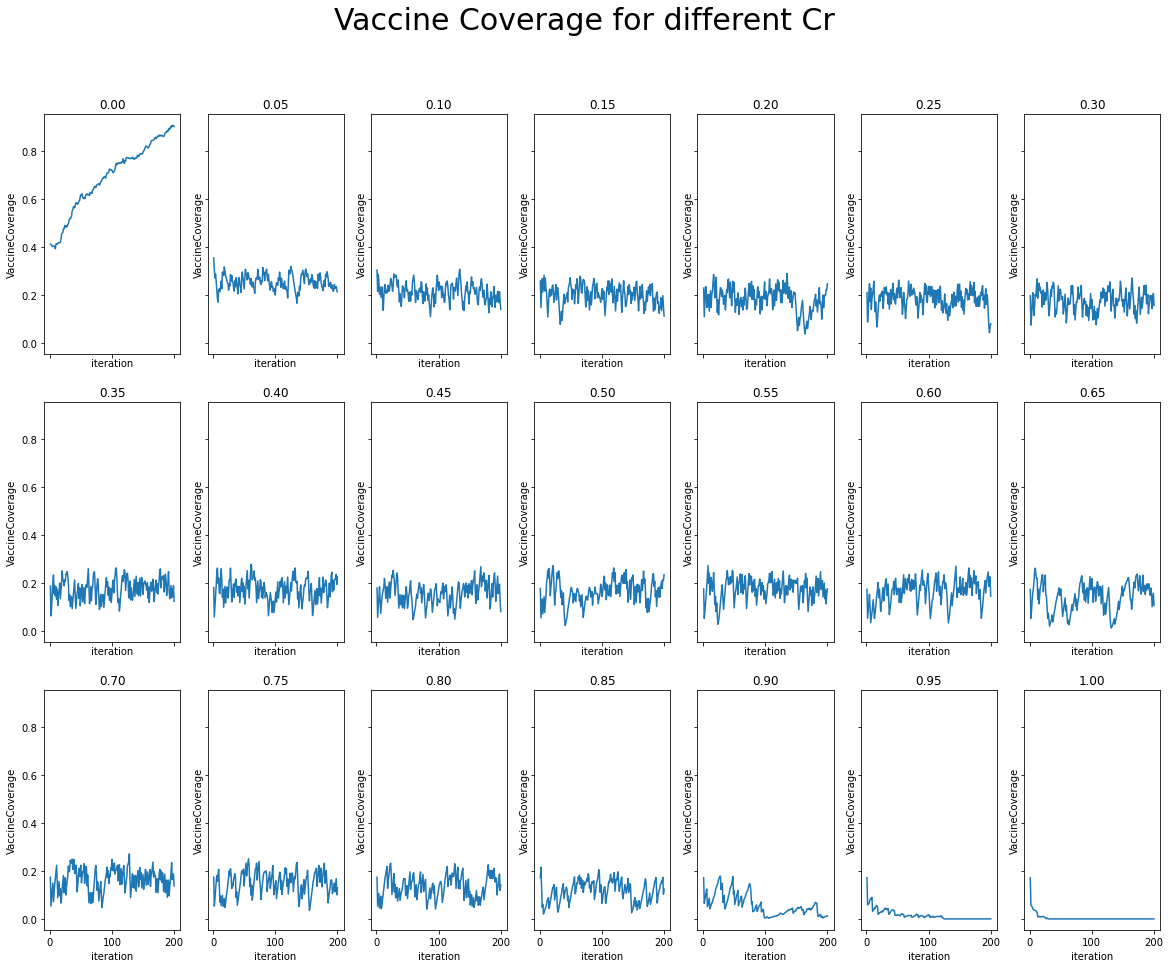

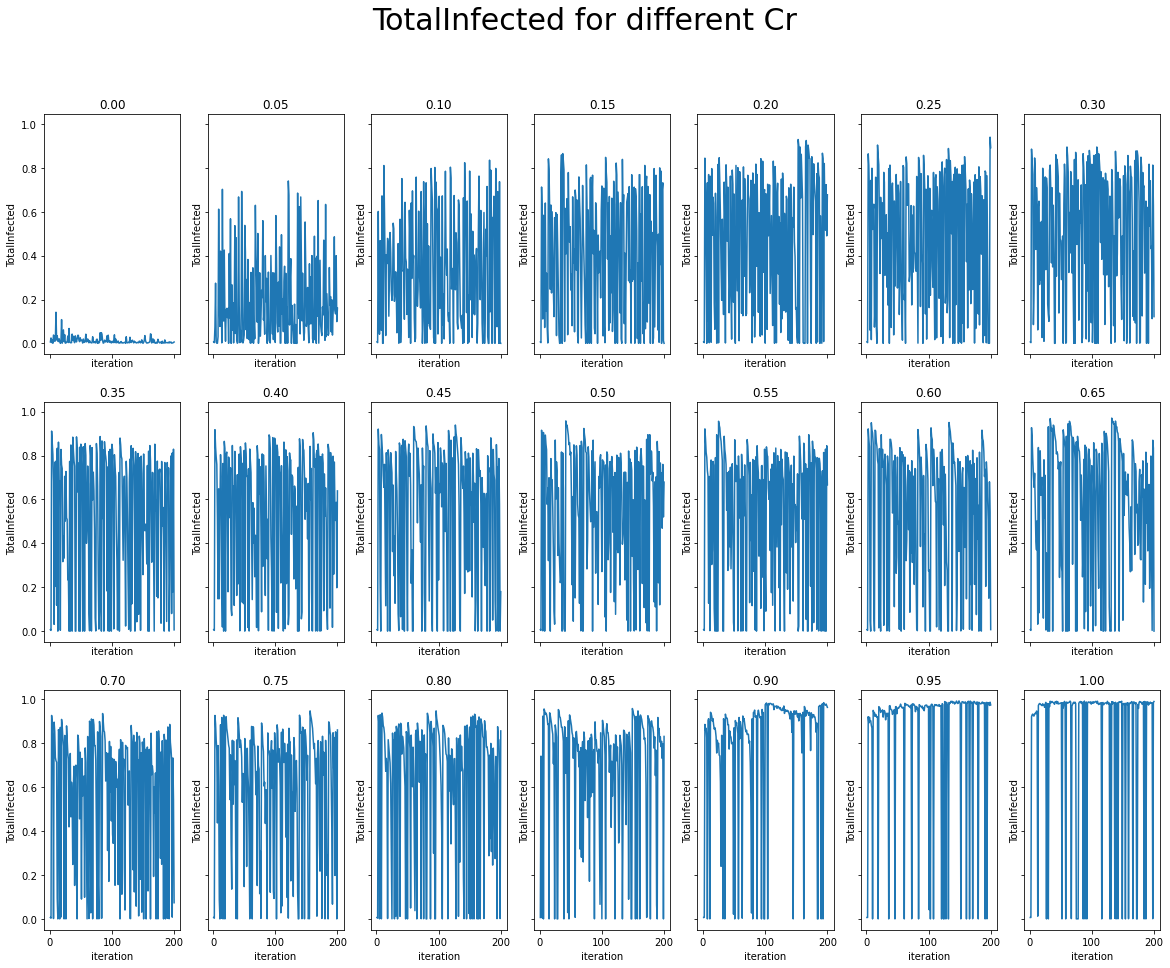

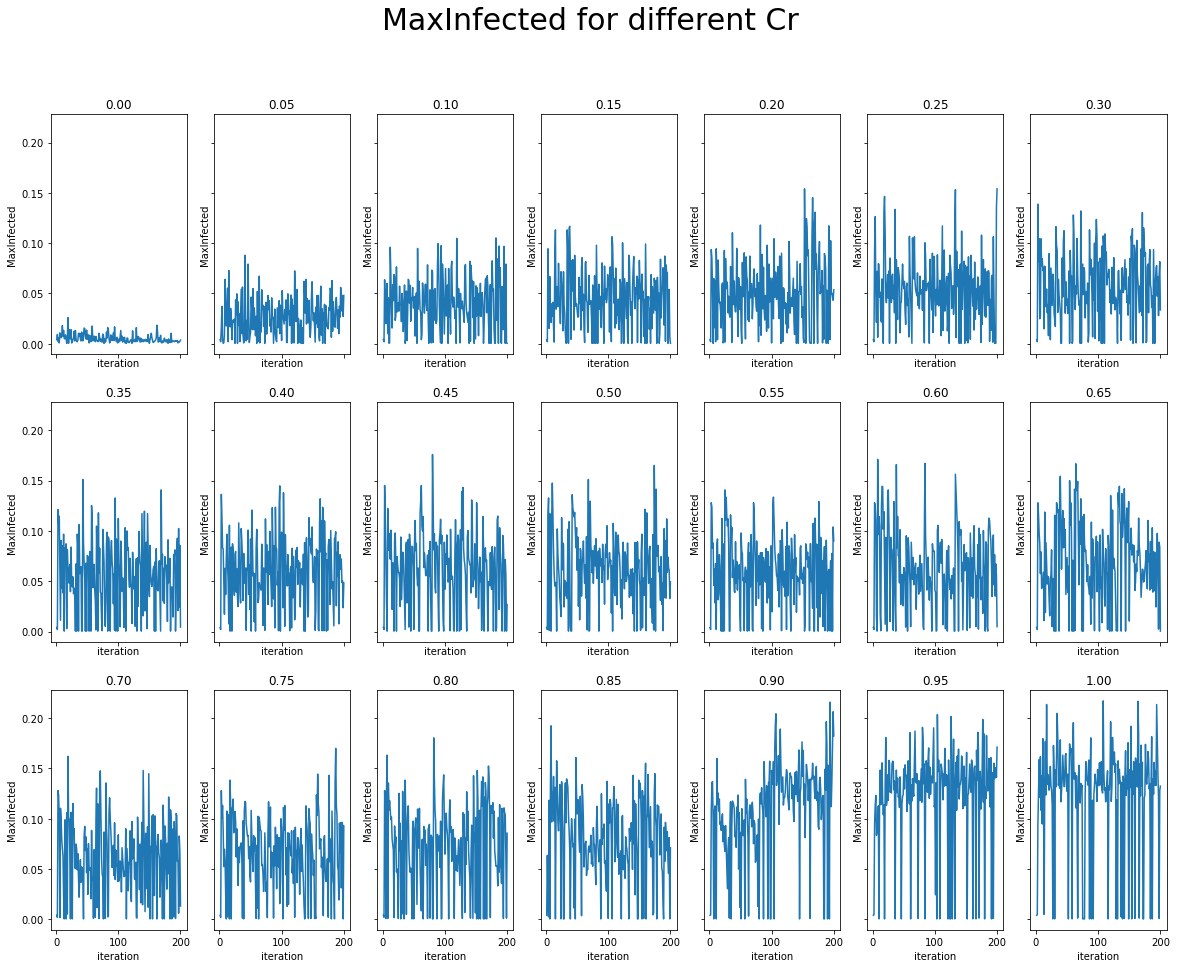

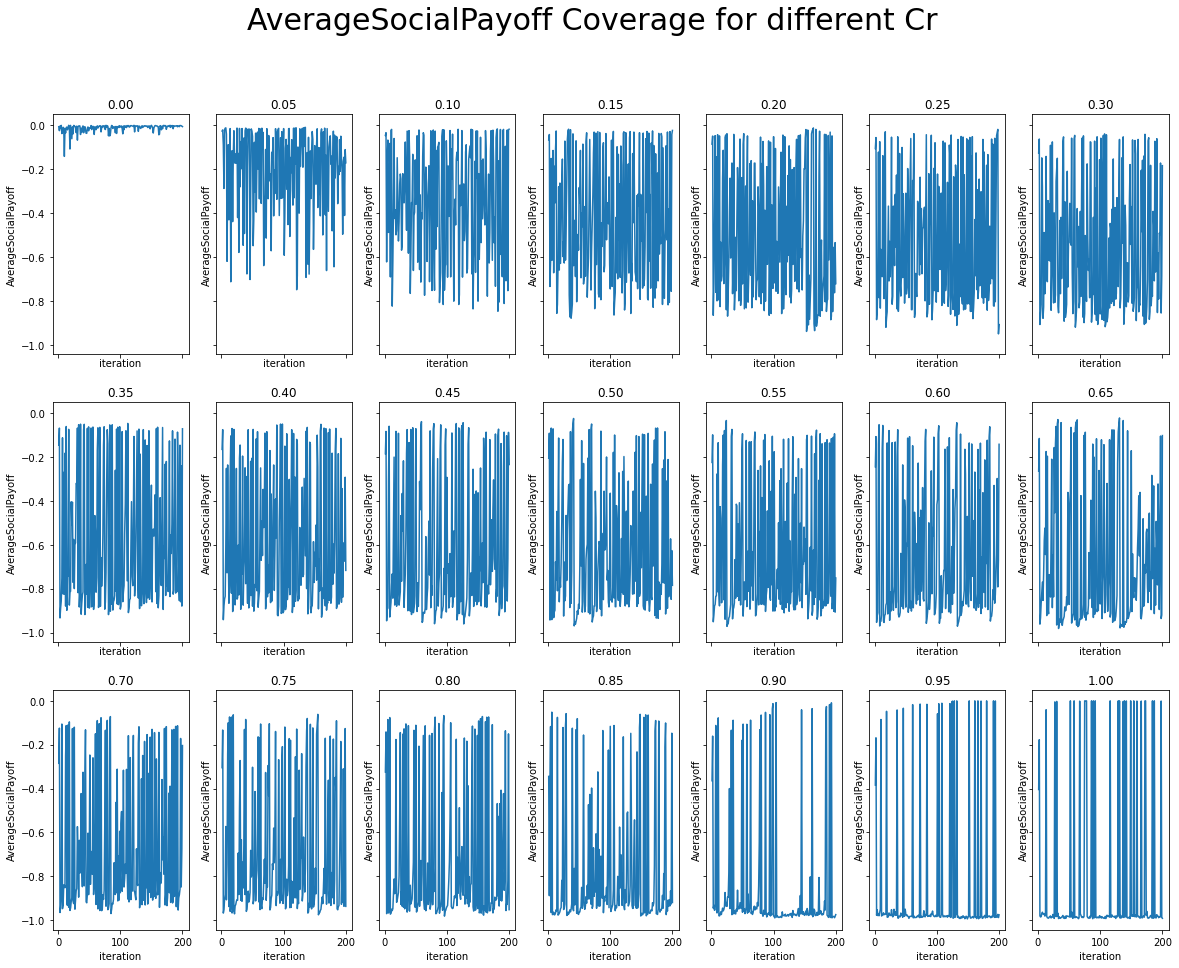

In [14]:
plot_list_dataframes_vs_iteration(dataframes_IB_RA, 'VaccineCoverage', Cr_list_str, 'IB_RA', 'Vaccine Coverage for different Cr')
plot_list_dataframes_vs_iteration(dataframes_IB_RA, 'TotalInfected', Cr_list_str, 'IB_RA' , 'TotalInfected for different Cr')
plot_list_dataframes_vs_iteration(dataframes_IB_RA, 'MaxInfected', Cr_list_str,  'IB_RA' , 'MaxInfected for different Cr')
plot_list_dataframes_vs_iteration(dataframes_IB_RA, 'AverageSocialPayoff', Cr_list_str, 'IB_RA' , 'AverageSocialPayoff Coverage for different Cr')

# SB_RA analysis

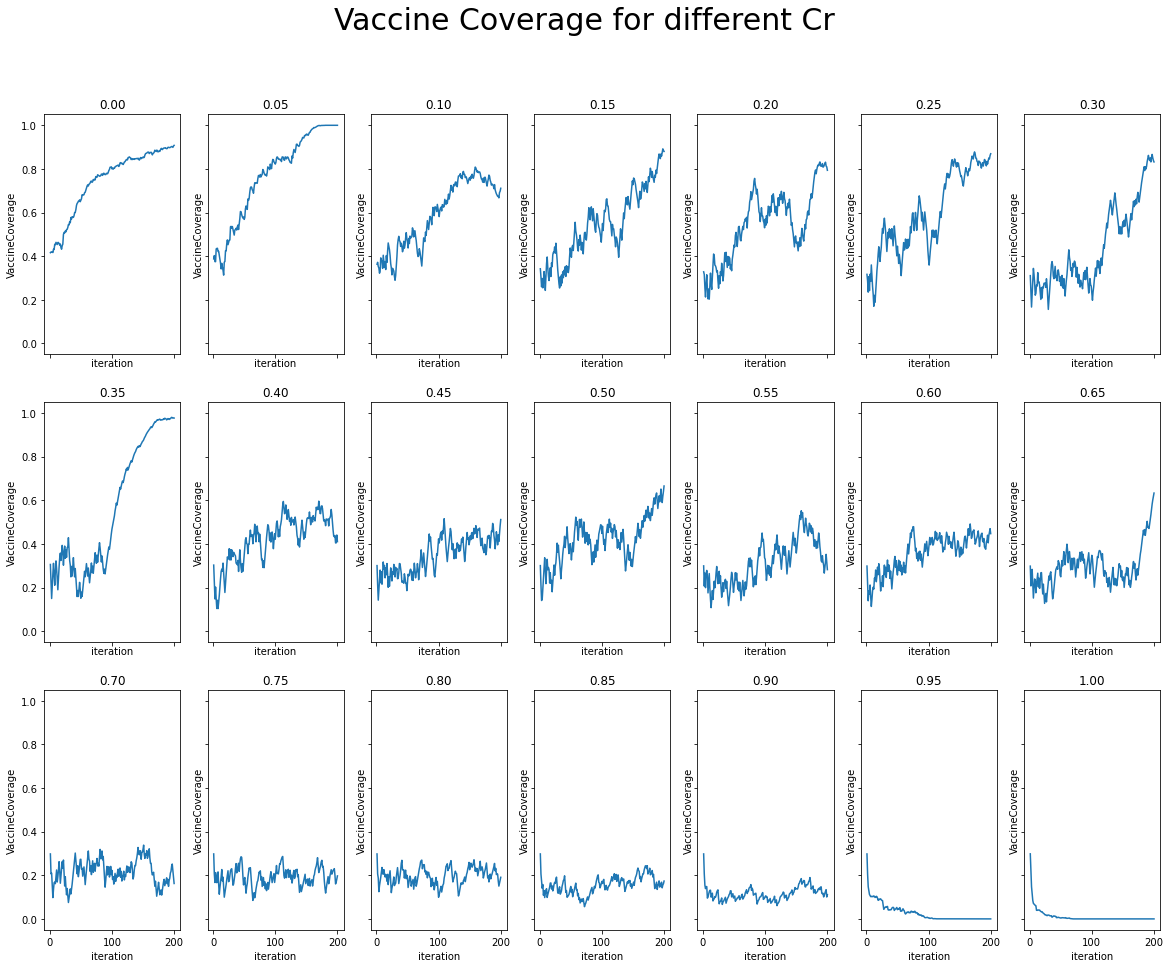

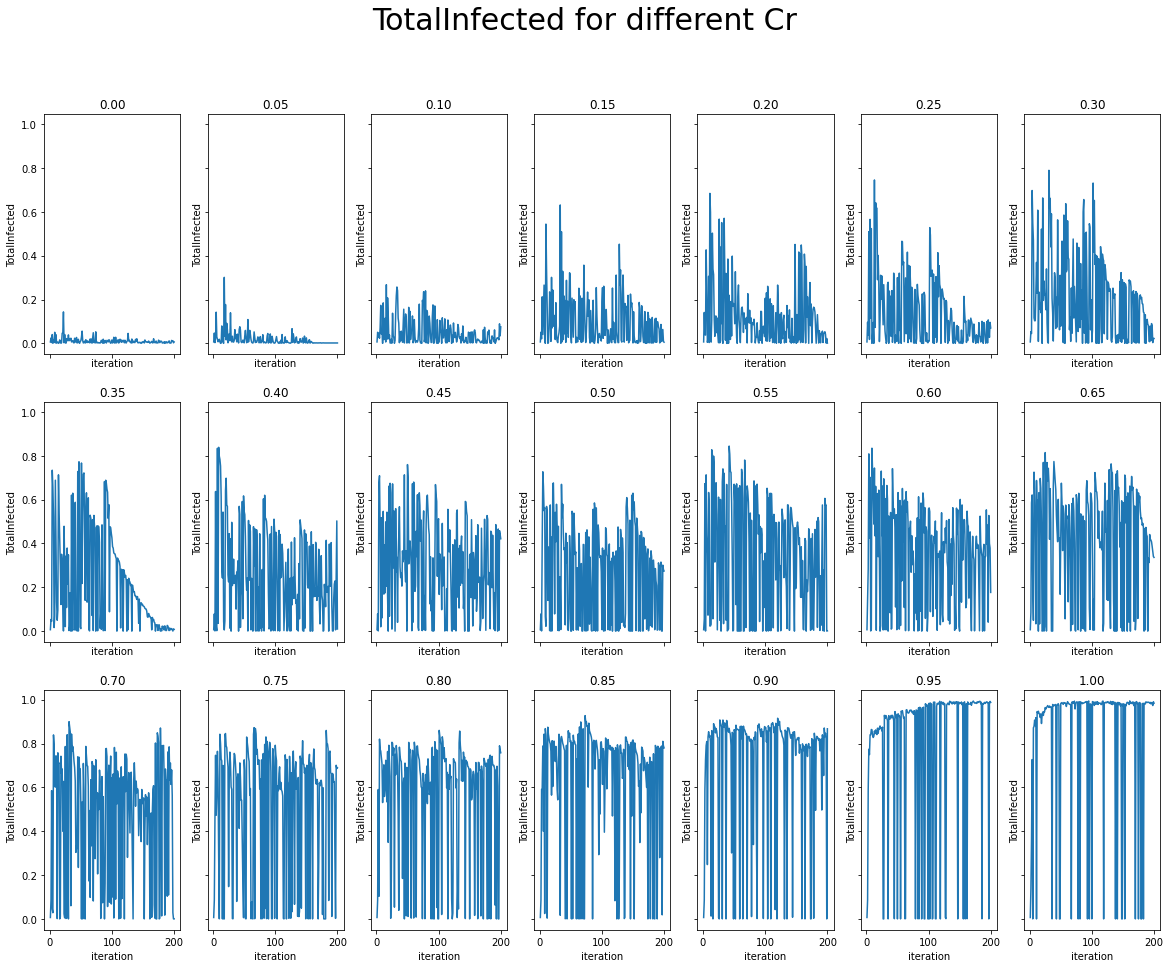

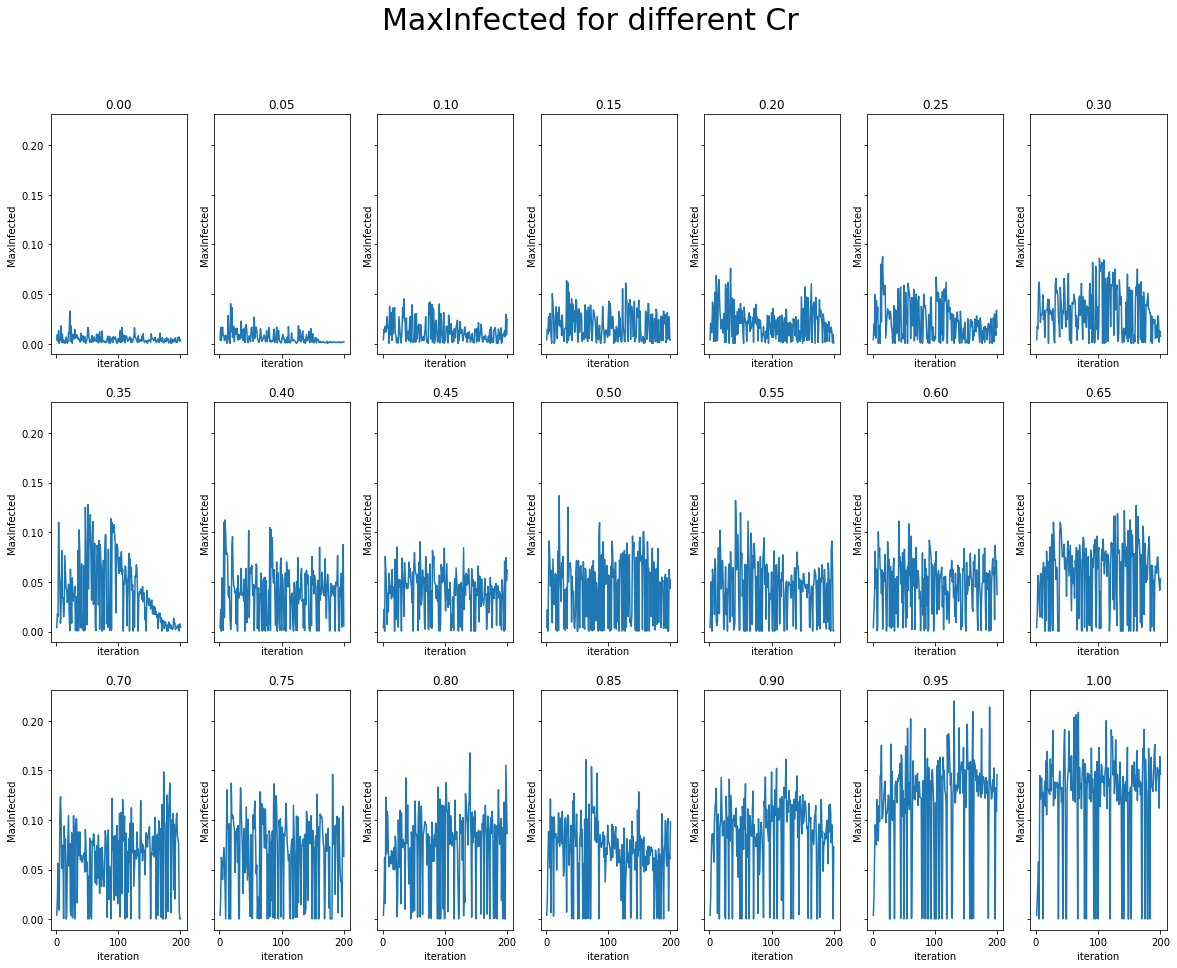

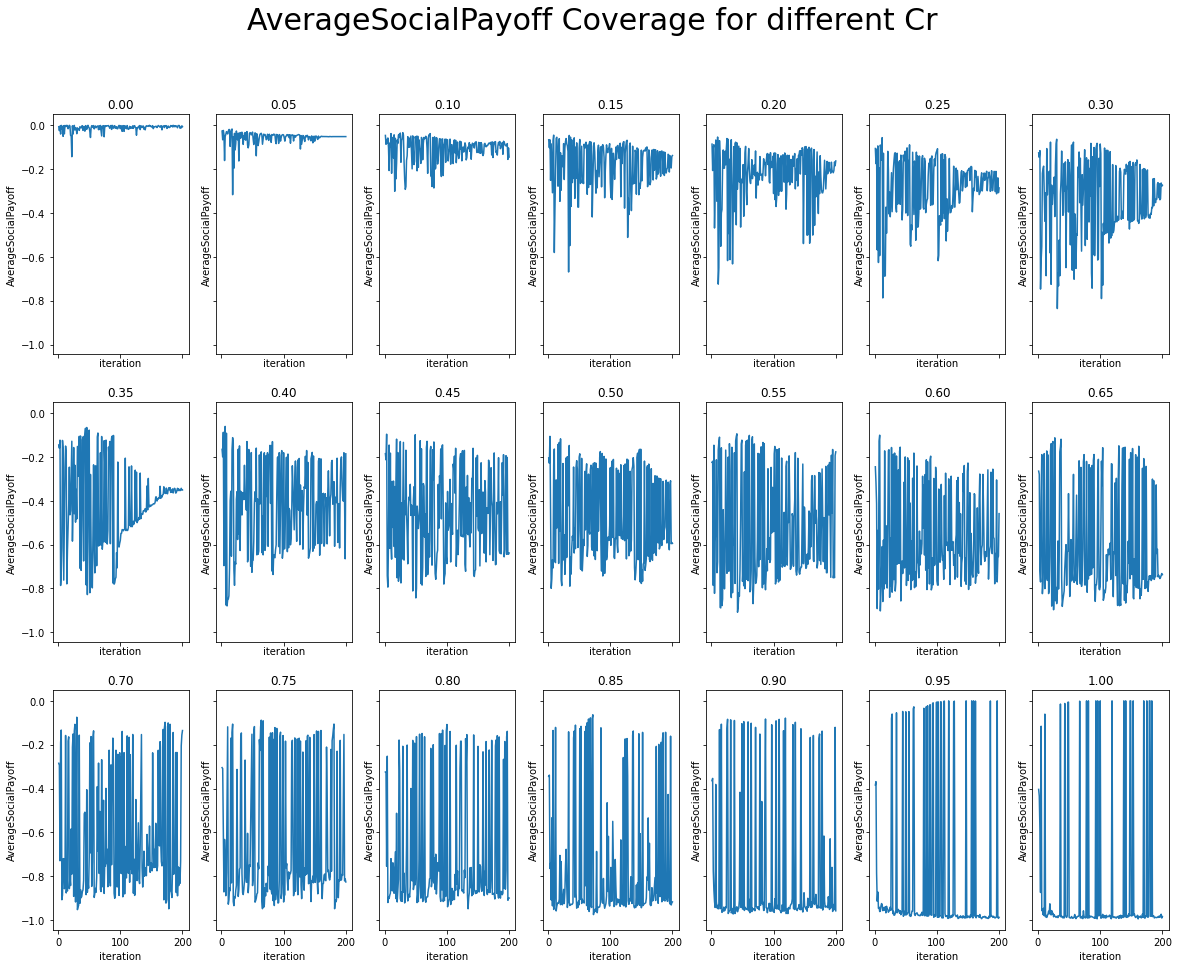

In [19]:
plot_list_dataframes_vs_iteration(dataframes_SB_RA, 'VaccineCoverage', Cr_list_str, 'SB_RA', 'Vaccine Coverage for different Cr')
plot_list_dataframes_vs_iteration(dataframes_SB_RA, 'TotalInfected', Cr_list_str, 'SB_RA' , 'TotalInfected for different Cr')
plot_list_dataframes_vs_iteration(dataframes_SB_RA, 'MaxInfected', Cr_list_str,  'SB_RA' , 'MaxInfected for different Cr')
plot_list_dataframes_vs_iteration(dataframes_SB_RA, 'AverageSocialPayoff', Cr_list_str, 'SB_RA' , 'AverageSocialPayoff Coverage for different Cr')

# FN_1 analysis

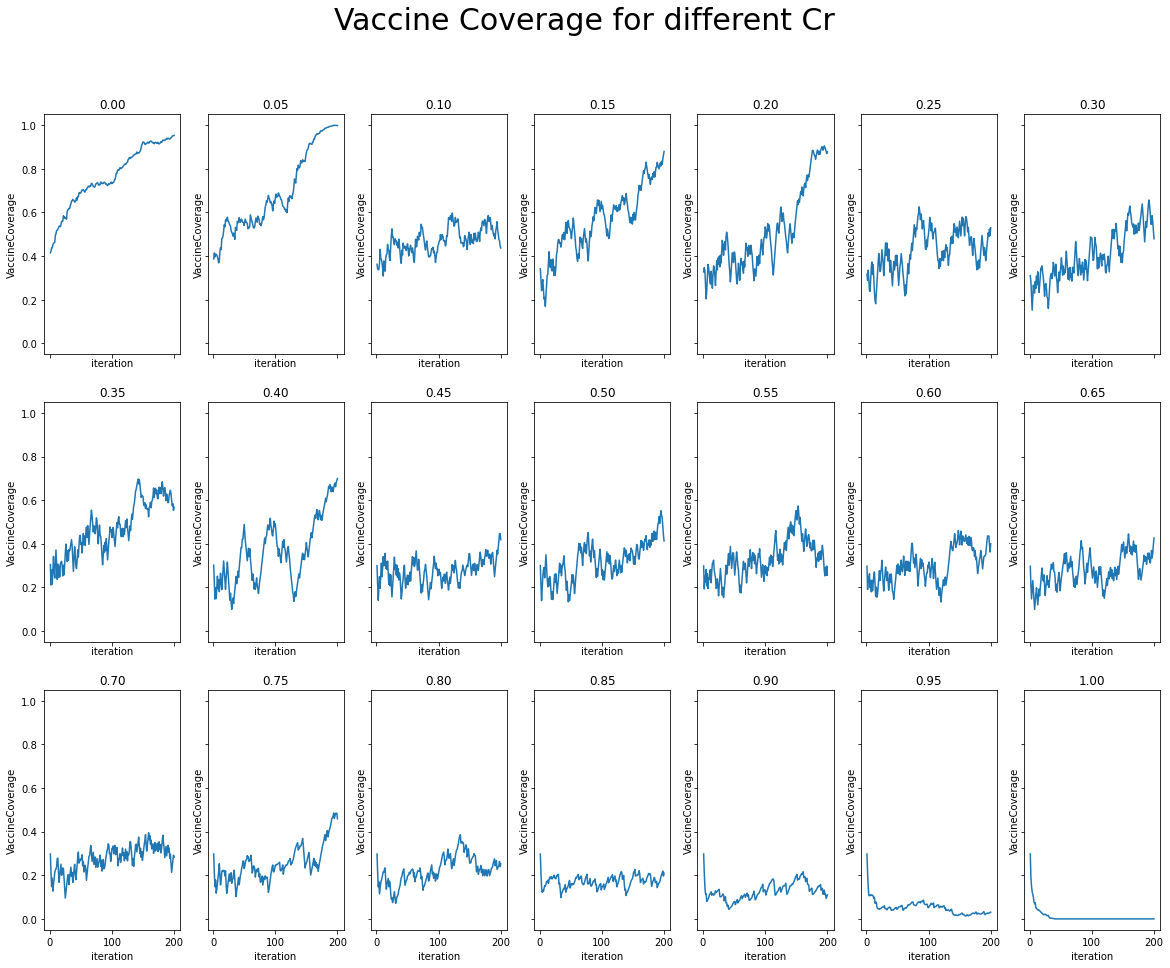

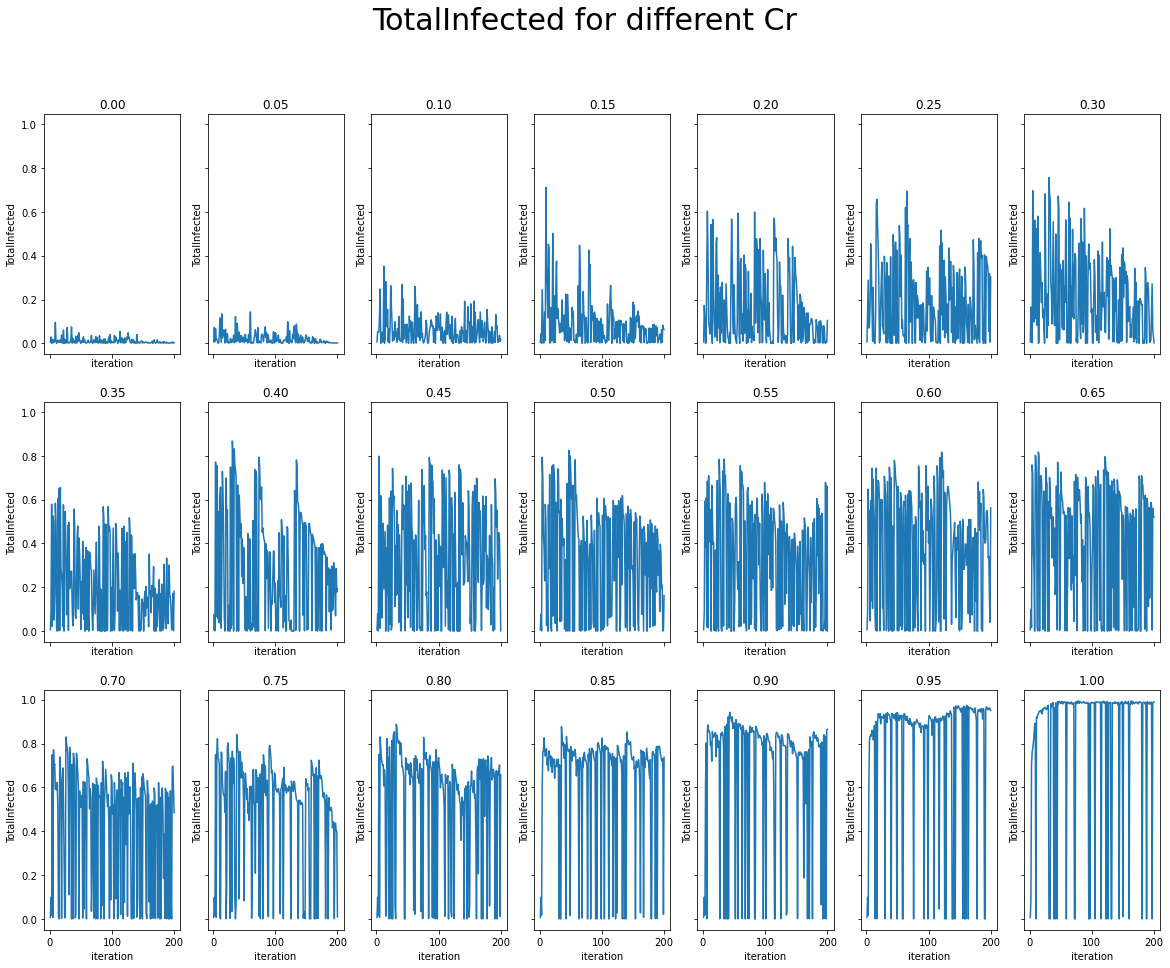

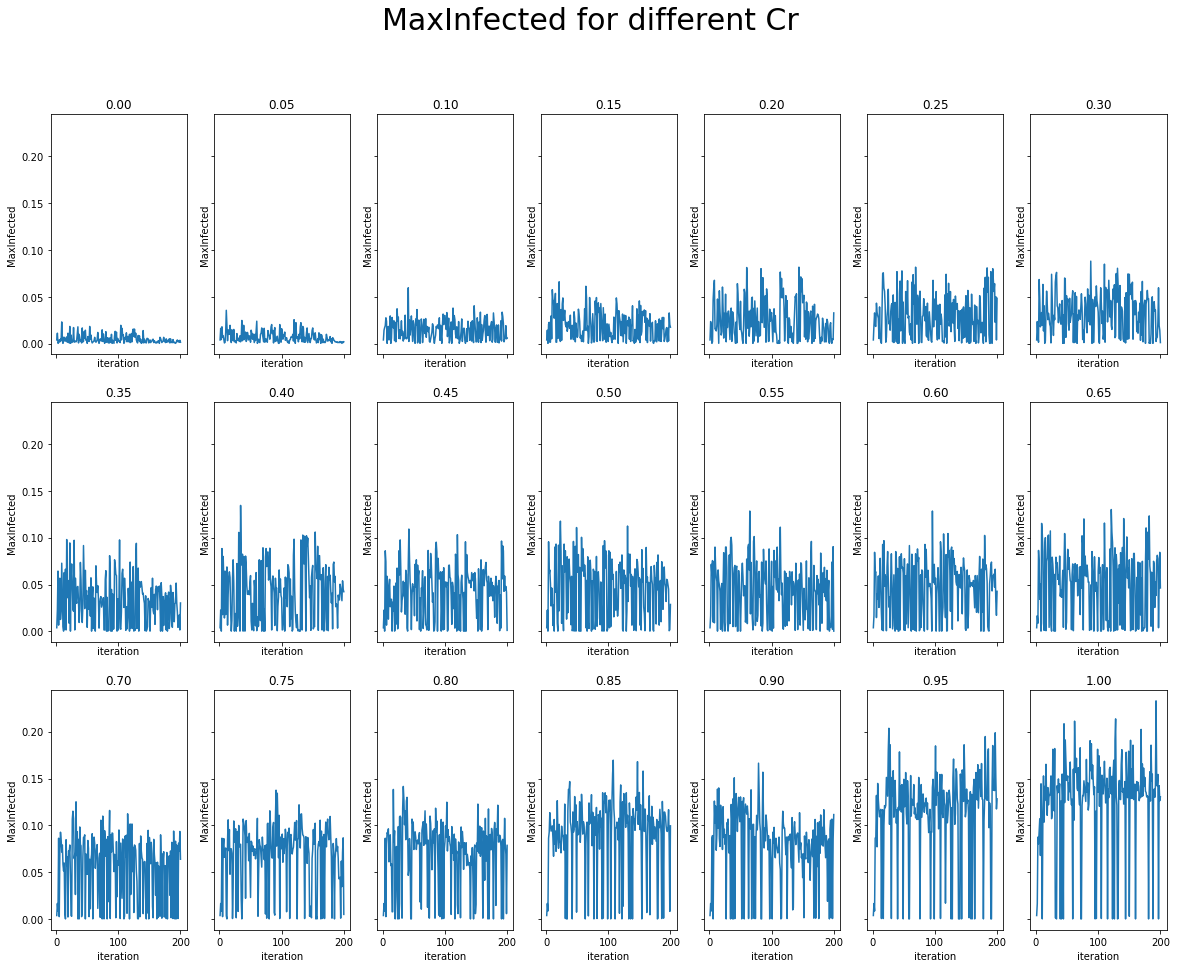

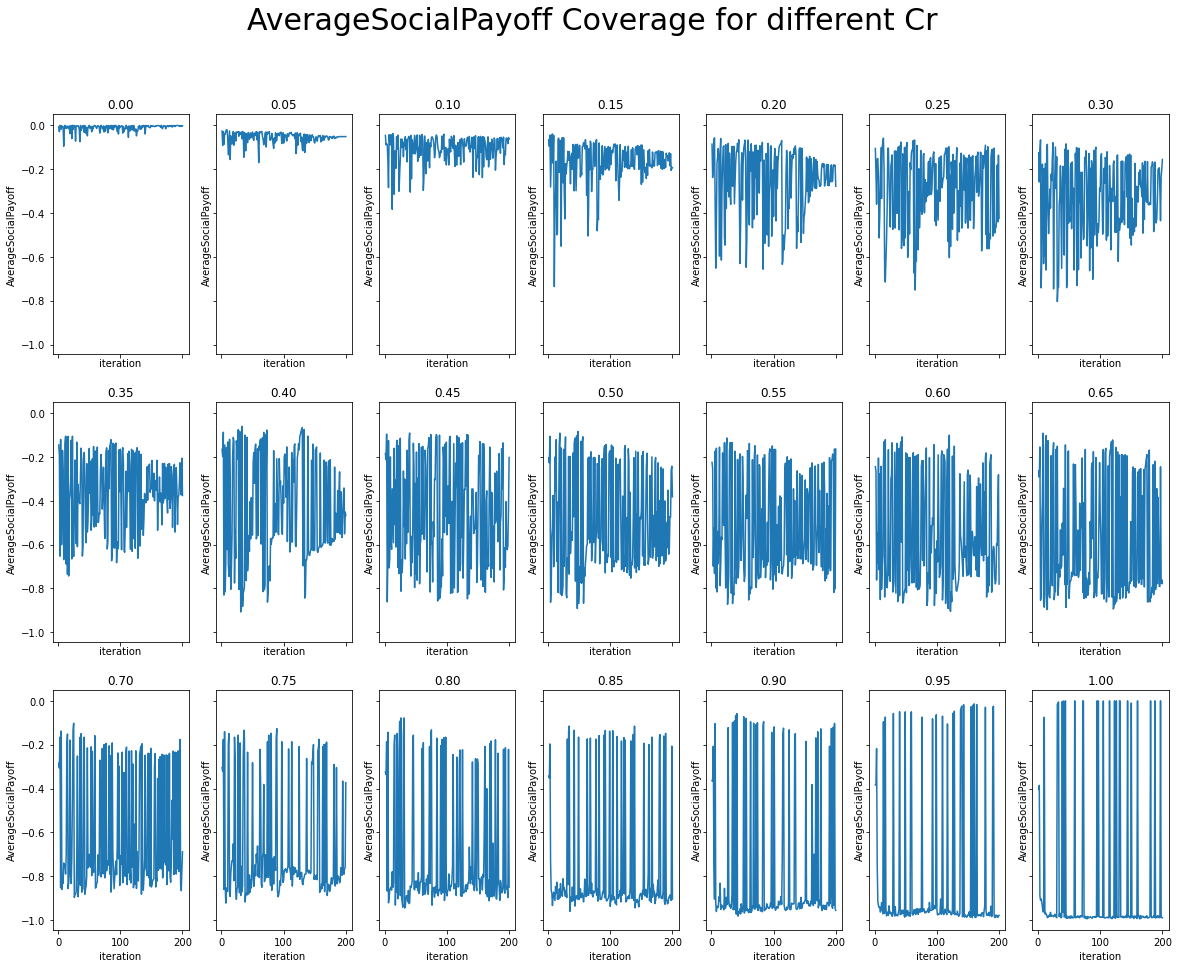

In [30]:
plot_list_dataframes_vs_iteration(dataframes_FN_1, 'VaccineCoverage', Cr_list_str, 'FN_1', 'Vaccine Coverage for different Cr')
plot_list_dataframes_vs_iteration(dataframes_FN_1, 'TotalInfected', Cr_list_str, 'FN_1' , 'TotalInfected for different Cr')
plot_list_dataframes_vs_iteration(dataframes_FN_1, 'MaxInfected', Cr_list_str,  'FN_1' , 'MaxInfected for different Cr')
plot_list_dataframes_vs_iteration(dataframes_FN_1, 'AverageSocialPayoff', Cr_list_str, 'FN_1' , 'AverageSocialPayoff Coverage for different Cr')

# FN_2 analysis

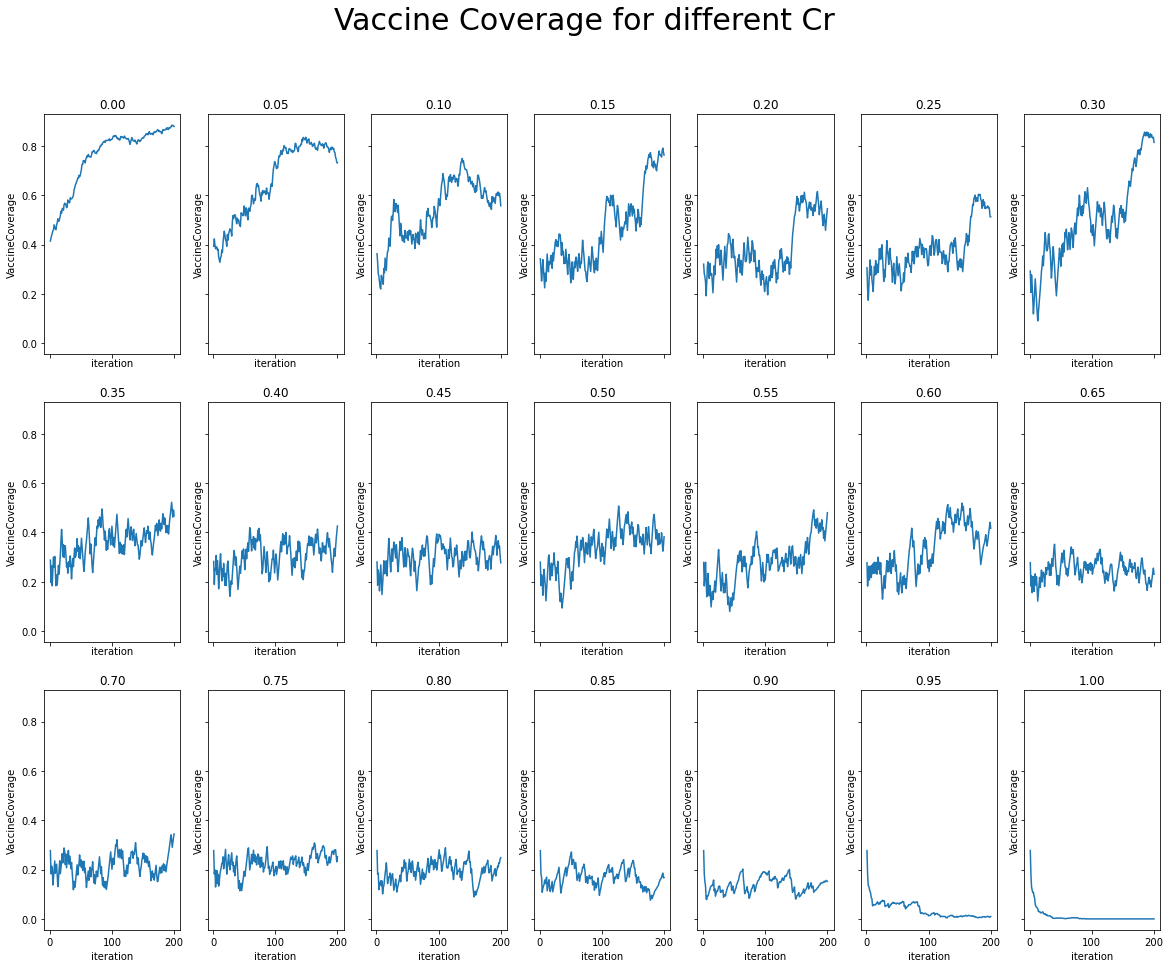

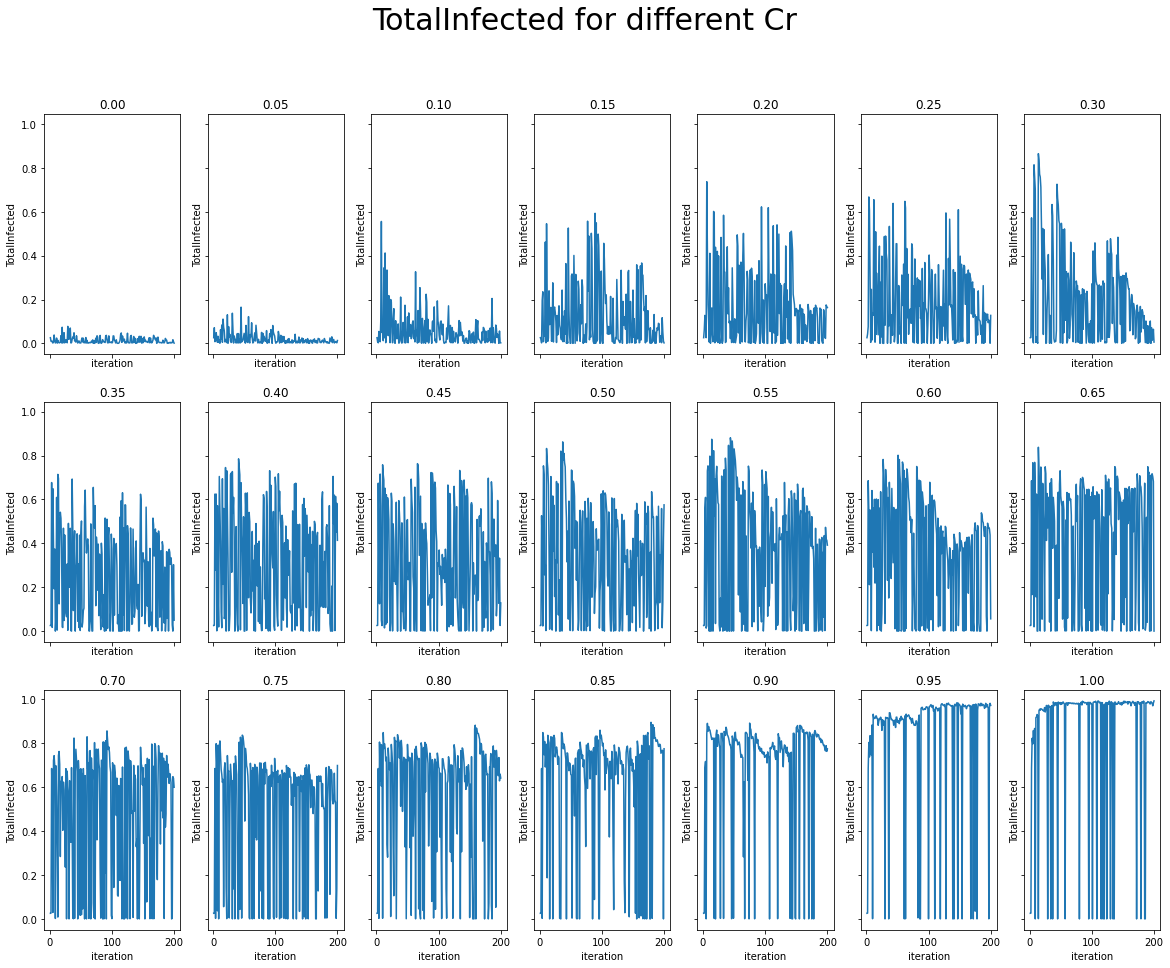

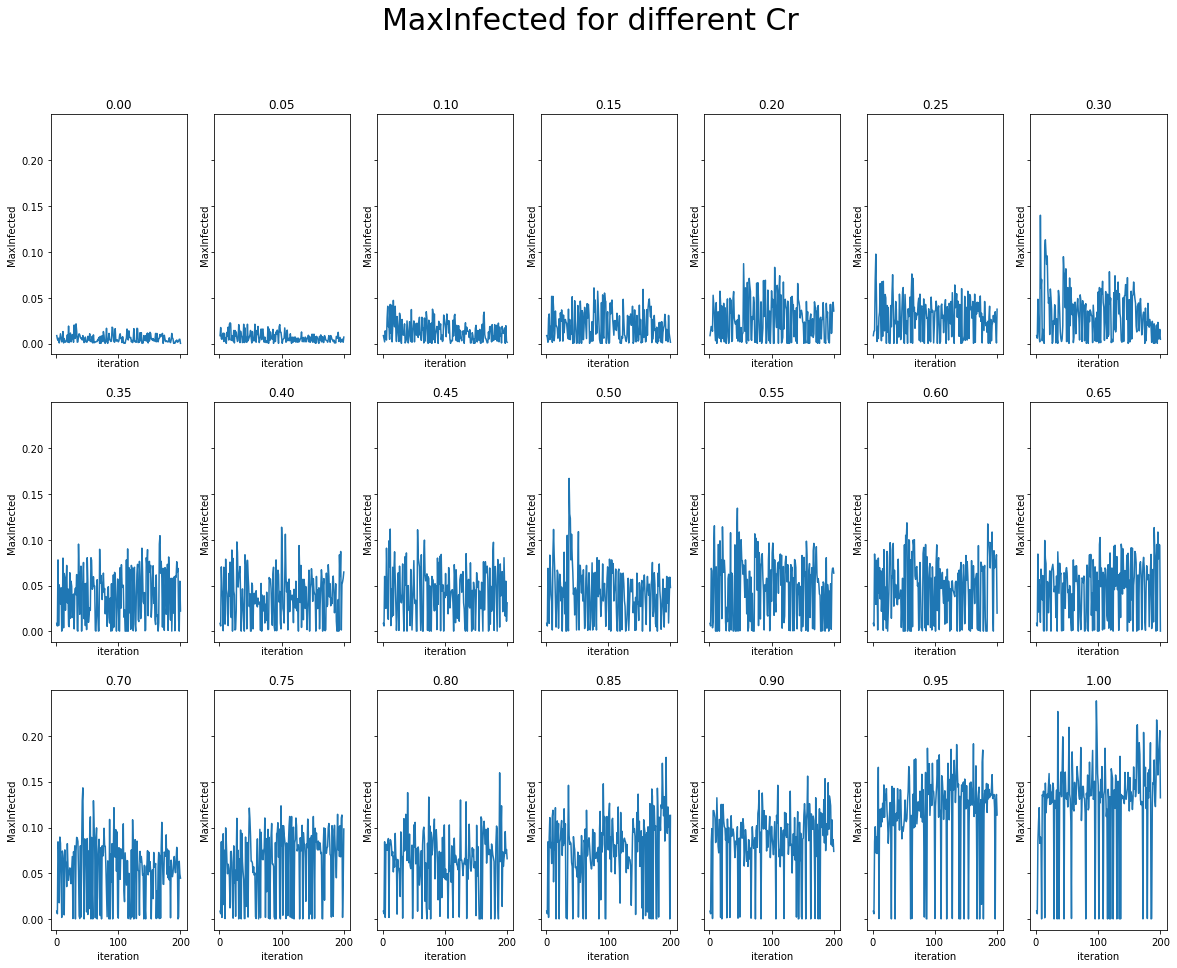

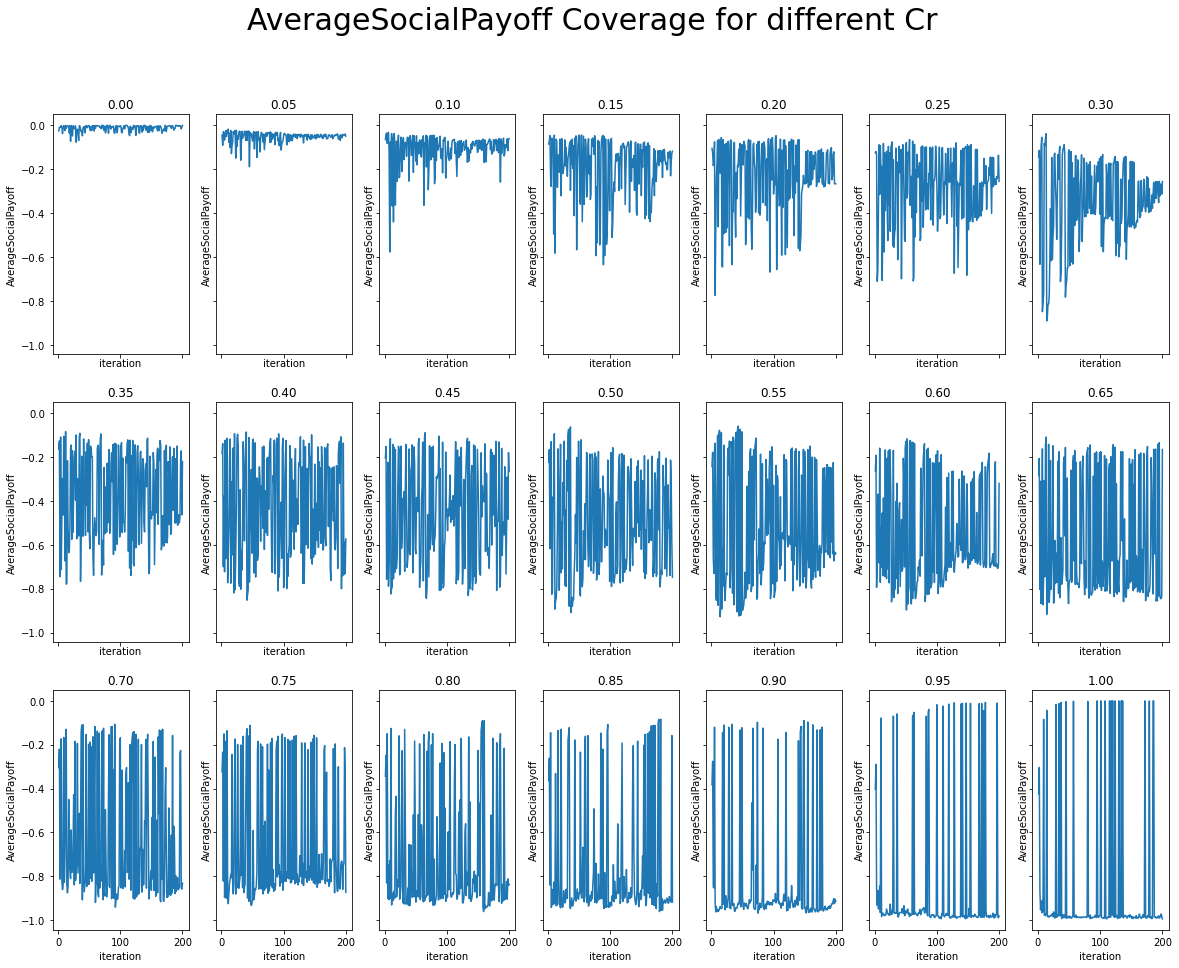

In [43]:
plot_list_dataframes_vs_iteration(dataframes_FN_2, 'VaccineCoverage', Cr_list_str, 'FN_2', 'Vaccine Coverage for different Cr')
plot_list_dataframes_vs_iteration(dataframes_FN_2, 'TotalInfected', Cr_list_str, 'FN_2' , 'TotalInfected for different Cr')
plot_list_dataframes_vs_iteration(dataframes_FN_2, 'MaxInfected', Cr_list_str,  'FN_2' , 'MaxInfected for different Cr')
plot_list_dataframes_vs_iteration(dataframes_FN_2, 'AverageSocialPayoff', Cr_list_str, 'FN_2' , 'AverageSocialPayoff Coverage for different Cr')

# Final databases

In [44]:
#discard first 50 iterations

IB_RA_VaccineCoverage_means = []
IB_RA_TotalInfected_means = []
IB_RA_MaxInfected_means = []
IB_RA_AverageSocialPayoff_means = []

SB_RA_VaccineCoverage_means = []
SB_RA_TotalInfected_means = []
SB_RA_MaxInfected_means = []
SB_RA_AverageSocialPayoff_means = []

FN_1_VaccineCoverage_means = []
FN_1_TotalInfected_means = []
FN_1_MaxInfected_means = []
FN_1_AverageSocialPayoff_means = []

FN_2_VaccineCoverage_means = []
FN_2_TotalInfected_means = []
FN_2_MaxInfected_means = []
FN_2_AverageSocialPayoff_means = []

IB_RA_df_definitive = [single_df[single_df.loc[:,'Iteration'] >= 50.].reset_index() for single_df in dataframes_IB_RA]
SB_RA_df_definitive = [single_df[single_df.loc[:,'Iteration'] >= 50.].reset_index() for single_df in dataframes_SB_RA]
FN_1_df_definitive = [single_df[single_df.loc[:,'Iteration'] >= 50.].reset_index() for single_df in dataframes_FN_1]
FN_2_df_definitive = [single_df[single_df.loc[:,'Iteration'] >= 50.].reset_index() for single_df in dataframes_FN_2]

for single_df in IB_RA_df_definitive:
    IB_RA_VaccineCoverage_means.append    (single_df.loc[:,'VaccineCoverage'].mean())
    IB_RA_TotalInfected_means.append      (single_df.loc[:,'TotalInfected'].mean())
    IB_RA_MaxInfected_means.append        (single_df.loc[:,'MaxInfected'].mean())
    IB_RA_AverageSocialPayoff_means.append(single_df.loc[:,'AverageSocialPayoff'].mean())
    
for single_df in SB_RA_df_definitive:
    SB_RA_VaccineCoverage_means.append    (single_df.loc[:,'VaccineCoverage'].mean())
    SB_RA_TotalInfected_means.append      (single_df.loc[:,'TotalInfected'].mean())
    SB_RA_MaxInfected_means.append        (single_df.loc[:,'MaxInfected'].mean())
    SB_RA_AverageSocialPayoff_means.append(single_df.loc[:,'AverageSocialPayoff'].mean())
    
for single_df in FN_1_df_definitive:
    FN_1_VaccineCoverage_means.append    (single_df.loc[:,'VaccineCoverage'].mean())
    FN_1_TotalInfected_means.append      (single_df.loc[:,'TotalInfected'].mean())
    FN_1_MaxInfected_means.append        (single_df.loc[:,'MaxInfected'].mean())
    FN_1_AverageSocialPayoff_means.append(single_df.loc[:,'AverageSocialPayoff'].mean())
    
for single_df in FN_2_df_definitive:
    FN_2_VaccineCoverage_means.append    (single_df.loc[:,'VaccineCoverage'].mean())
    FN_2_TotalInfected_means.append      (single_df.loc[:,'TotalInfected'].mean())
    FN_2_MaxInfected_means.append        (single_df.loc[:,'MaxInfected'].mean())
    FN_2_AverageSocialPayoff_means.append(single_df.loc[:,'AverageSocialPayoff'].mean())

# Final Plots

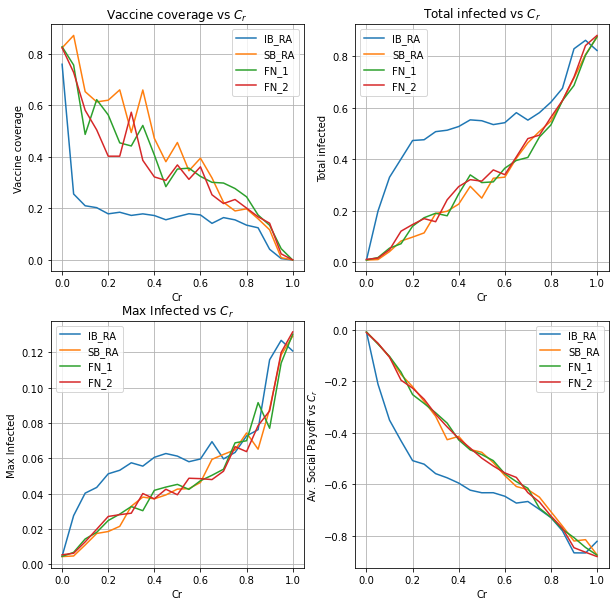

In [50]:
fig, ax = plt.subplots(2,2, figsize = (10,10))

ax[0,0].plot(Cr_list, np.array(IB_RA_VaccineCoverage_means), '-' , label = 'IB_RA')
ax[0,0].plot(Cr_list, np.array(SB_RA_VaccineCoverage_means), '-' , label = 'SB_RA')
ax[0,0].plot(Cr_list, np.array(FN_1_VaccineCoverage_means), '-' , label = 'FN_1')
ax[0,0].plot(Cr_list, np.array(FN_2_VaccineCoverage_means), '-' , label = 'FN_2')
ax[0,0].set_ylabel('Vaccine coverage')
ax[0,0].set_title('Vaccine coverage vs $C_r$')


ax[0,1].plot(Cr_list, np.array(IB_RA_TotalInfected_means), '-' , label = 'IB_RA')
ax[0,1].plot(Cr_list, np.array(SB_RA_TotalInfected_means), '-' , label = 'SB_RA')
ax[0,1].plot(Cr_list, np.array(FN_1_TotalInfected_means), '-' , label = 'FN_1')
ax[0,1].plot(Cr_list, np.array(FN_2_TotalInfected_means), '-' , label = 'FN_2')
ax[0,1].set_ylabel('Total infected')
ax[0,1].set_title('Total infected vs $C_r$')


ax[1,0].plot(Cr_list, np.array(IB_RA_MaxInfected_means), '-' , label = 'IB_RA')
ax[1,0].plot(Cr_list, np.array(SB_RA_MaxInfected_means), '-' , label = 'SB_RA')
ax[1,0].plot(Cr_list, np.array(FN_1_MaxInfected_means), '-' , label = 'FN_1')
ax[1,0].plot(Cr_list, np.array(FN_2_MaxInfected_means), '-' , label = 'FN_2')
ax[1,0].set_ylabel('Max Infected')
ax[1,0].set_title('Max Infected vs $C_r$')


ax[1,1].plot(Cr_list, np.array(IB_RA_AverageSocialPayoff_means), '-' , label = 'IB_RA')
ax[1,1].plot(Cr_list, np.array(SB_RA_AverageSocialPayoff_means), '-' , label = 'SB_RA')
ax[1,1].plot(Cr_list, np.array(FN_1_AverageSocialPayoff_means), '-' , label = 'FN_1')
ax[1,1].plot(Cr_list, np.array(FN_2_AverageSocialPayoff_means), '-' , label = 'FN_2')
ax[1,1].set_ylabel('Av. Social Payoff')
ax[1,1].set_ylabel('Av. Social Payoff vs $C_r$')


for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel('Cr')
        ax[i,j].legend()
        ax[i,j].grid(True)    
    
plt.savefig('Results')

In [ ]:
print(720//50, 720%50)
print(1358//50, 1358%50)

# Prove del codice

In [ ]:
#initialization
N = 50
timesteps = 5
G = nx.grid_2d_graph(N, N)
G = nx.convert_node_labels_to_integers(G)
strategy = nx.number_of_nodes(G)*['S']

# totally random
for i in range(2000):
    seed = np.random.choice(range(len(strategy)))
    strategy[seed] = 'V'
print("Fraction of population vaccinated is:", strategy.count('V')/(N*N))

init_strat = strategy.copy()
vaccine_fraction_IB_RA = []
vaccine_fraction_IB_RA.append(strategy.count('V')/(N*N))
total_infected_IB_RA = []


columns = ['Iteration', 'VaccineCoverage', 'TotalInfected', 'MaxInfected', 'AverageSocialPayoff']
results = pd.DataFrame(columns=columns)
vacc_cover   = strategy.count('V')/(N*N)
total_infec  = df.tail(1).R.values[0]
av_payoff    = mean(payoffs_values)
max_infected = max(df.I)
results.loc[len(results)] = [i, vacc_cover, total_infec, max_infected, av_payoff]



#dynamics using IB_RA update
for i in range(timesteps):
    print(i,"/",timesteps)
    df, statuses   = gillespieSIRV(G, 1, 0.4, 1000, strategy)
    total_infected_IB_RA.append(df.tail(1).R.values[0])
    payoffs_values = get_payoff(statuses, 0.2, N)
    new_strategies = IB_RA_update(strategy, payoffs_values, G)
    strategy       = new_strategies.copy()
    vaccine_fraction_IB_RA.append(strategy.count('V')/(N*N))


plot_strategy_square_lattice(init_strat, N, "Initial")
plot_strategy_square_lattice(strategy, N, "Final")

In [ ]:
#initialization
N = 50
G = nx.grid_2d_graph(N, N)
G = nx.convert_node_labels_to_integers(G)
strategy = nx.number_of_nodes(G)*['S']

# totally random
for i in range(2000):
    seed = np.random.choice(range(len(strategy)))
    strategy[seed] = 'V'
print("Fraction of population vaccinated is:", strategy.count('V')/(N*N))

init_strat = strategy.copy()
vaccine_fraction_SB_RA = []
vaccine_fraction_SB_RA.append(strategy.count('V')/(N*N))
total_infected_SB_RA = []

#dynamics using SB_RA update
for i in range(timesteps):
    print(i,"/",timesteps)
    df, statuses   = gillespieSIRV(G, 1, 0.4, 1000, strategy)
    total_infected_SB_RA.append(df.tail(1).R.values[0])
    payoffs_values = get_payoff(statuses, 0.2, N)
    new_strategies = SB_RA_update(strategy, payoffs_values, G, 0)
    strategy = new_strategies.copy()
    vaccine_fraction_SB_RA.append(strategy.count('V')/(N*N))
    
plot_strategy_square_lattice(init_strat, N, "Initial")
plot_strategy_square_lattice(strategy, N, "Final")

In [ ]:
plt.plot(np.arange(timesteps + 1), np.array(vaccine_fraction_IB_RA), label = 'IB_RA')
plt.plot(np.arange(timesteps + 1), np.array(vaccine_fraction_SB_RA), label = 'SB_RA')
plt.legend()
plt.xlabel('timestep')
plt.ylabel('Vaccination coverage')
plt.title('Vaccination coverage vs Timestep')
plt.show()


plt.plot(np.arange(timesteps), np.array(total_infected_IB_RA), label = 'IB_RA')
plt.plot(np.arange(timesteps), np.array(total_infected_SB_RA), label = 'SB_RA')
plt.legend()
plt.xlabel('timestep')
plt.ylabel('Infected vs timestep')
plt.title('Infected fraction vs Timestep')
plt.show()

fig, ax = plt.subplots(1,2, figsize = (12,8))
ax[0].plot(np.arange(timesteps), np.array(vaccine_fraction_IB_RA)[:-1], label = 'vaccine coverage')
ax[0].plot(np.arange(timesteps), np.array(total_infected_IB_RA), label = 'total infected')
ax[0].set_xlabel('timestep')
ax[0].set_ylabel('fraction')
ax[0].set_title("IB_RA strategy update")
ax[0].legend()


ax[1].plot(np.arange(timesteps), np.array(vaccine_fraction_SB_RA)[:-1], label = 'vaccine coverage')
ax[1].plot(np.arange(timesteps), np.array(total_infected_SB_RA), label = 'total infected')
ax[1].set_xlabel('timestep')
ax[1].set_ylabel('fraction')
ax[1].set_title("SB_RA strategy update")
ax[1].legend()
plt.show()

In [ ]:
plot_SIRV_results_square_lattice(statuses, N)

In [ ]:
for i in G.neighbors(55):
    print(i)

In [ ]:
plt.plot(datas.Time, datas.S, label = 'S')
plt.plot(datas.Time, datas.I, label = 'I')
plt.plot(datas.Time, datas.R, label = 'R')
plt.legend()
plt.show()

In [ ]:
datas

In [ ]:
lista_statuses     = 15*['S']
lista_statuses[12] = 'V'
lista_statuses[5]  = 'V'
lista_statuses[10] = 'V'

lista_statuses.count('S')

In [ ]:
statuses = nx.number_of_nodes(G)*['S']
for i in range(100):
    seed = np.random.choice(range(len(statuses)))
    statuses[seed] = 'V'

In [ ]:
df, statuses = gillespieSIRV(G, 0.5, 0.2, 40, statuses)
#https://stackoverflow.com/questions/10194482/custom-matplotlib-plot-chess-board-like-table-with-colored-cells

In [ ]:
#https://stackoverflow.com/questions/43971138/python-plotting-colored-grid-based-on-values
def find_colour(_val):
    # Colour value constants
    _colours = {"blue": [0.0, 0.0, 1.0],
                "green": [0.0, 1.0, 0.00],
                "yellow": [1.0, 1.0, 0.0],
                "red": [1.0, 0.0, 0.0]}

    # Map the value to a colour
    _colour = [0, 0, 0]
    if _val == 'V':
        _colour = _colours["blue"]
    elif _val == 'S':
        _colour = _colours["green"]
    elif _val == 'I':
        _colour = _colours["yellow"]
    elif _val == 'R':
        _colour = _colours["red"]

    return tuple(_colour)

colors = find_colour(statuses[0])
colors

In [ ]:
#map statuses to color
# V -> 0
# S -> 1
# I -> 2
# R -> 3

def map_status_to_value(statuses_list):
    vals = []
    for i in statuses_list:
        if i == 'V':
            vals.append(0)
        elif i == 'S':
            vals.append(1)
        elif i == 'I':
            vals.append(2)
        elif i == 'R':
            vals.append(3)
        
    return np.array(vals)

values = map_status_to_value(statuses).reshape((N,N))

cMap = ListedColormap(['blue', 'green', 'yellow','red'])
# bounds = [-0.1,0.9,1.9,2.9,3.9]
# norm = colors.BoundaryNorm(bounds, cmap.N)

In [ ]:
# create discrete colormap
fig, ax = plt.subplots(figsize = (10,10))
img = ax.imshow(values, cmap=cMap)

#legend
cbar = plt.colorbar(img)
#empty the ticks of cbar
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['V', 'S', 'I', 'R']):
    cbar.ax.text(1.5, 0.75*j+0.35, lab, ha='center', va ='center', fontsize = '25')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Node type', rotation=90, fontsize = '25')

ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xlim([-.5,float(N)-0.5])
ax.set_ylim([-.5,float(N)-0.5])

labels = [str(i) for i in range(N)]
ax.set_xticks(np.arange(-.5, N , 1))
ax.set_yticks(np.arange(-.5, N , 1))

empty_string_labels = ['']*len(np.arange(-.5, N , 1))
ax.set_xticklabels(empty_string_labels)
ax.set_yticklabels(empty_string_labels)
ax.invert_yaxis()
plt.title('SIRV - final snapshot', fontsize = '25')
plt.show()

In [ ]:
def map_status_to_value(statuses_list):
    vals = []
    for i in statuses_list:
        if i == 'V':
            vals.append(0)
        elif i == 'S':
            vals.append(1)
        elif i == 'I':
            vals.append(2)
        elif i == 'R':
            vals.append(3)
        
    return np.array(vals)


def plot_SIRV_results(values):
    
    values = map_status_to_value(statuses).reshape((N,N))
    cMap = ListedColormap(['blue', 'green', 'yellow','red'])
    
    fig, ax = plt.subplots(figsize = (10,10))
    img = ax.imshow(values, cmap=cMap)

    #legend
    cbar = plt.colorbar(img)
    #empty the ticks of cbar
    cbar.ax.get_yaxis().set_ticks([])
    for j, lab in enumerate(['V', 'S', 'I', 'R']):
        cbar.ax.text(1.5, 0.75*j+0.35, lab, ha='center', va ='center', fontsize = '25')
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Node type', rotation=90, fontsize = '25')

    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xlim([-.5,float(N)-0.5])
    ax.set_ylim([-.5,float(N)-0.5])

    labels = [str(i) for i in range(N)]
    ax.set_xticks(np.arange(-.5, N , 1))
    ax.set_yticks(np.arange(-.5, N , 1))

    empty_string_labels = ['']*len(np.arange(-.5, N , 1))
    ax.set_xticklabels(empty_string_labels)
    ax.set_yticklabels(empty_string_labels)
    ax.invert_yaxis()
    plt.title('SIRV - final snapshot', fontsize = '25')
    plt.show()